# Model Development and Training

In this Jupyter Notebook, you will develop and train the model.

In [384]:
### Importing...
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import missingno as msno
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


### Connecting to PostgreSQL to access database

In [385]:
# reads the whole API
conn2 = ps.connect(dbname = "postgres",
                   user = "postgres",
                   password = "postgres",
                   host = "localhost",
                   port = "5432")

In [386]:
# connect np2025_area table
area_sql = """select * 
fROM public.np2025_area"""

# connect np2025_farm table
farm_sql = """select * 
fROM public.np2025_farm"""

# connect np2025_product_final table
product_sql = """select * 
fROM public.np2025_product_final"""

# connect np2025_sale_order table
so_sql = """select * 
fROM public.np2025_sale_order"""

# connect np2025_sale_order_item table
soi_sql = """select * 
fROM public.np2025_sale_order_item"""

# connect feedback table
feedback_sql = """select *
fROM public.feedback"""

# connect product_clicks table
product_clicks_sql = """select *
fROM public.product_clicks"""

# connect user_session table
user_session_sql = """select *
fROM public.user_session"""

In [387]:
# read area table
area_df = sqlio.read_sql_query(area_sql, conn2)

# read farm table
farm_df = sqlio.read_sql_query(farm_sql, conn2)

# read product table
product_df = sqlio.read_sql_query(product_sql, conn2)

# read sale_order table
so_df = sqlio.read_sql_query(so_sql, conn2)

# read sale_order_item table
soi_df = sqlio.read_sql_query(soi_sql, conn2)

# read feedback table
feedback_df = sqlio.read_sql_query(feedback_sql, conn2)

# read product_clicks table
product_clicks_df = sqlio.read_sql_query(product_clicks_sql, conn2)

# read user_session table
user_session_df = sqlio.read_sql_query(user_session_sql, conn2)

C:\Users\user\AppData\Local\Temp\ipykernel_27872\440608200.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  area_df = sqlio.read_sql_query(area_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_27872\440608200.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  farm_df = sqlio.read_sql_query(farm_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_27872\440608200.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product_df = sqlio.read_sql_query(product_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_278

In [388]:
# show the first 5 rows of the area_df DataFrame
area_df.head()

,id,name,level_0,level_1,level_2,level_3,level_3_latitude,level_3_longitude,level_4,level_4_latitude,level_4_longitude
0,ID1209191006,"Kisaran Kota, Kisaran Barat, Asahan, Sumatera Utara",Indonesia,Sumatera Utara,Asahan,Kota Kisaran Barat,2.98124,99.61624,Kisaran Kota,2.983163,99.627871
1,ID1209201009,"Kisaran Naga, Kisaran Timur, Asahan, Sumatera Utara",Indonesia,Sumatera Utara,Asahan,Kota Kisaran Timur,2.98984,99.63970,Kisaran Naga,2.967763,99.625784
2,ID1209201011,"Karang Anyer, Kisaran Timur, Asahan, Sumatera Utara",Indonesia,Sumatera Utara,Asahan,Kota Kisaran Timur,2.98984,99.63970,Karang Anyer,3.007047,99.648056
3,ID1209201012,"Gambir Baru, Kisaran Timur, Asahan, Sumatera Utara",Indonesia,Sumatera Utara,Asahan,Kota Kisaran Timur,2.98984,99.63970,Gambir Baru,2.997273,99.636919
4,ID1101092001,"Keude Trumon, Trumon, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Trumon,2.63444,97.74167,Keude Trumon,2.795277,97.672874


In [389]:
# show the first 5 rows of the farm_df DataFrame
farm_df.head()

,id,owner_id,area_id,latitude,longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare,soil_type,seed_type
0,75670847-1557-4ae2-99b8-12fe9515a41e,59addfcc-8bb1-45fa-8928-0d4dfcdf6044,ID1403032003,NaN,NaN,4.0,NaN,NaN,NaN,None,None
1,8b935705-5db4-4817-b924-b3d7648e3e78,648e2b96-3e32-4670-ae70-f95ee2062c88,ID1406112004,NaN,NaN,15.0,NaN,NaN,NaN,None,None
2,9d377e85-8548-4ab7-833a-2ac30cab8b5b,4d99df25-94d6-44fd-8062-82c34d1fd5fb,ID1471061013,NaN,NaN,15.0,NaN,NaN,NaN,None,None
3,0825a3c3-2069-4c92-a238-9af2783ba3d8,79bce53b-87a5-4c46-9cec-63214e51ce18,ID1404142004,NaN,NaN,20.0,NaN,NaN,NaN,None,None
4,ac0dee42-dd4b-478a-aaa6-dce3d47986d7,e7780f70-3658-450f-bf4f-cc37fd02ded7,ID1406072007,NaN,NaN,140.0,NaN,NaN,NaN,None,None


In [390]:
# show the first 5 rows of the product_df DataFrame
product_df.head()

,id,sku,type,name,unit_of_measurement,price,description
0,a5e58550-e659-4e32-aa4d-9467cc974da6,SAWITPRO-03,SERVICE,Uji Sampel Daun,kg,799000.0,Uji Sampel Daun <p><br>
1,5110ed03-9e1e-44bd-913c-4f56de2dcf0b,MERCH-SAWITPRO-CAP-01,GOODS,Topi SawitPRO Hijau,kg,35000.0,Topi berlogo SawitPRO warna Hijau Topi berlogo SawitPRO warna Hijau
2,74075fc0-bdee-45ef-8083-f1f3d94ee581,MERCH-SAWITPRO-GOODIEBAG-01,GOODS,Kaos Agen Inovasi + Topi Hijau + Goodie Bag,kg,90000.0,Paket Goodie Bag Merchandise Resmi SawitPRO <p>Paket terdiri dari:</p><p>1 Kaos Agen Inovasi SawitPRO ukuran L</p><p>1 Topi Hijau SawitPRO</p><p>1 Goodie Bag SawitPRO</p>
3,4770a993-5aa3-4186-a41e-f39d7541df51,MERCH-SAWITPRO-SHIRT-01,GOODS,Kaos Agen Inovasi SawitPRO size L,kg,60000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Agen Inovasi"".\nUkuran All-size (XL) <p>Kaos tidak berkerah warna Putih bertuliskan ""Agen Inovasi"".\nUkuran All-size (L)</p>"
4,b2c98d7b-744a-4fe9-bddd-8205380b84d5,MERCH-SAWITPRO-POLO-01,GOODS,Kaos Polo SawitPRO ukuran XL,kg,150000.0,Kaos Sawitpro Edisi Pertama didominasi warna Kuning dan Hijau <p>Kaos Polo SawitPRO ukuran XL</p><p><br></p><p>Detail Ukuran:</p><ul><li>Tinggi Baju : <strong>76 cm</strong></li><li>Lebar bagian Dada : <strong>54 cm</strong></li></ul><p><br></p><p>Hubungi Tim Kami untuk memesan ukuran berbeda.</p>


In [391]:
# show the first 5 rows of the so_df DataFrame
so_df.head()

,id,user_id,total_item_price,created_at_utc0
0,5efc1940-ffbc-42d5-971c-c371f0f9e4d0,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719571211174
1,8bc2245e-9139-49d2-8dcf-a5bf987f95e6,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719570526244
2,a063780d-98f2-45ce-80b4-4a5dc6c88913,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719570162699
3,fb4edf76-6023-43f0-b7f7-33d60944fcba,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719570066683
4,f77509f8-af76-4b52-a581-d986af60fab3,bc9cef21-d236-4d71-adb2-ca7b71a5264d,210000.0,1719569546696


In [392]:
# show the first 5 rows of the soi_df DataFrame
soi_df.head()

,id,sale_order_id,product_id,quantity,price
0,c9c618d4-6a87-4fe6-b599-f70a8eb945e5,93b24b37-97df-40dc-9ee6-feb0ec53e3db,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0
1,676d47f9-5990-4a92-b6cc-7a6167bc095f,4633e76f-9730-4177-b7d3-7e3f07fceb44,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0
2,4b245235-7a25-4025-a61e-d0e6fbbbfc1d,2dacc8ea-6bca-4526-8fb8-cff62bc76cc4,9aab3102-3aee-4639-b7f6-4dd33933c675,100000,1.0
3,106f766a-3cb2-4ca1-b5de-d23659ce21f8,b8947fb5-9cee-4d1a-bc93-502f1dfd6ca5,6c27fc9c-e7e9-4e9b-9017-292175250df1,260000,100.0
4,502a4281-eb71-4433-9ab9-20995779d8a2,4dfebad3-a88f-4aea-8217-c262b80c1594,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0


In [393]:
# show the first 5 rows of the feedback_df DataFrame
feedback_df.head()

,feedback_id,sales_order_id,rating,comment
0,e4a7c3f1-2d9b-486e-90c5-1d6f8b7a5e3c,d20a9066-aed8-4082-98e6-7abc62b7bf78,5,Exceeded expectations in every way!
1,9b8c7d6e-5f4a-43b2-a1c0-d9e8f7a6b5c4,ba87bf4a-4099-4101-84fb-ef0248fdf987,4,"Very good service, would recommend."
2,2f3e4d5c-6b7a-4897-a6b5-c4d3e2f1a0b9,e465e104-5248-4bd6-8650-4388f1a37e0f,3,"Average experience, nothing special."
3,a8b7c6d5-e4f3-4a2b-91c0-d9e8f7a6b5c4,86496962-031e-4f39-a78c-dd907bcd7322,5,"Absolutely perfect, couldn't ask for more."
4,5c6d7e8f-9a0b-4c1d-82e3-f4a5b6c7d8e9,a1c52691-d8de-4613-84f0-c78abf103cac,2,"Disappointed with quality, needs improvement."


In [394]:
# show the first 5 rows of the product_clicks_df DataFrame
product_clicks_df.head()

,prodct_clicks_id,product_id,timestamp
0,b9c8d7e6-f5a4-4b3c-92d1-e0f9a8b7c6d5,0bd2430a-6613-442a-9d5a-11d64cb095ae,2025/05/01 08:05:00
1,3a4b5c6d-7e8f-4a0b-81c2-d3e4f5a6b7c8,1033503b-8faa-4d5c-97c2-50bb19fbb897,2025/03/17 14:32:45
2,e0f1a2b3-c4d5-4e6f-87a8-b9c0d1e2f3a4,1af0394e-3aea-42b4-8698-b6832e35f8ce,2025/07/29 09:18:22
3,7a8b9c0d-1e2f-4a3b-84c5-d6e7f8a9b0c1,2485b082-5258-44c1-b6aa-983387d540a7,2025/04/12 16:45:37
4,1e2f3a4b-5c6d-47e8-8f9a-0b1c2d3e4f5a,2b8fe2f0-5d07-459c-8781-22305a61980a,2025/06/05 11:09:54


In [395]:
# show the first 5 rows of the user_session_df DataFrame
user_session_df.head()

,user_session_id,user_id,session_start,session_end
0,d20a9066-aed8-4082-98e6-7abc62b7bf78,05ebeca1-5a73-46ec-88fc-323b29d468cc,2025/03/15 09:23:17,2025/03/15 10:47:32
1,5f3c8b1a-6d24-4ea7-b519-f32c0e48d92c,7a341d40-7166-46d4-b37f-be9a9ecec7f7,2025/04/22 14:05:39,2025/04/22 15:38:51
2,a7f9e031-2bcd-4568-9174-8d26e0b7c943,34e01958-7a5d-4016-bb9a-e36d87ed3bf6,2025/01/08 18:32:45,2025/01/08 19:15:12
3,16eb7d42-5c9a-4f83-b0e5-3a192d4c6b87,917278db-9719-4988-a151-237f4fc74b9d,2025/07/19 08:17:23,2025/07/19 11:03:45
4,c8b53e9f-471d-4a20-9c8e-0b7d2f961a45,b93b8e2b-ffa7-4e29-bbf1-c90cce4c0962,2025/02/28 16:45:10,2025/02/28 17:22:38


In [396]:
# show shape of the area_df DataFrame
area_df.shape

(5794, 11)

In [397]:
# show shape of the farm_df DataFrame
farm_df.shape

(10828, 11)

In [398]:
# show shape of the product_df DataFrame
product_df.shape

(40, 7)

In [399]:
# show shape of the so_df DataFrame 
so_df.shape

(802, 4)

In [400]:
# show shape of the soi_df DataFrame
soi_df.shape

(812, 5)

In [401]:
# show shape of the feedback_df DataFrame
feedback_df.shape

(41, 4)

In [402]:
# show shape of the product_clicks_df DataFrame
product_clicks_df.shape

(41, 3)

In [403]:
# show shape of the user_session_df DataFrame
user_session_df.shape

(41, 4)

In [404]:
# show data types of the area_df DataFrame
area_df.dtypes

id                    object
name                  object
level_0               object
level_1               object
level_2               object
level_3               object
level_3_latitude     float64
level_3_longitude    float64
level_4               object
level_4_latitude     float64
level_4_longitude    float64
dtype: object

In [405]:
# show data types of the farm_df DataFrame
farm_df.dtypes

id                         object
owner_id                   object
area_id                    object
latitude                  float64
longitude                 float64
area_hectare              float64
planted_year              float64
planted_month             float64
palm_trees_per_hectare    float64
soil_type                  object
seed_type                  object
dtype: object

In [406]:
# show data types of the product_df DataFrame
product_df.dtypes

id                      object
sku                     object
type                    object
name                    object
unit_of_measurement     object
price                  float64
description             object
dtype: object

In [407]:
# show data types of the so_df DataFrame
so_df.dtypes

id                   object
user_id              object
total_item_price    float64
created_at_utc0       int64
dtype: object

In [408]:
# show data types of the soi_df DataFrame
soi_df.dtypes

id                object
sale_order_id     object
product_id        object
quantity           int64
price            float64
dtype: object

In [409]:
# show data types of the feedback_df DataFrame
feedback_df.dtypes

feedback_id       object
sales_order_id    object
rating            object
comment           object
dtype: object

In [410]:
# show data types of the product_clicks_df DataFrame
product_clicks_df.dtypes

prodct_clicks_id    object
product_id          object
timestamp           object
dtype: object

In [411]:
# show data types of the user_session_df DataFrame
user_session_df.dtypes

user_session_id    object
user_id            object
session_start      object
session_end        object
dtype: object

In [412]:
area_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5794 non-null   object 
 1   name               5794 non-null   object 
 2   level_0            5794 non-null   object 
 3   level_1            5794 non-null   object 
 4   level_2            5794 non-null   object 
 5   level_3            5794 non-null   object 
 6   level_3_latitude   5794 non-null   float64
 7   level_3_longitude  5794 non-null   float64
 8   level_4            5794 non-null   object 
 9   level_4_latitude   5794 non-null   float64
 10  level_4_longitude  5794 non-null   float64
dtypes: float64(4), object(7)
memory usage: 498.1+ KB


In [413]:
farm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10828 entries, 0 to 10827
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10828 non-null  object 
 1   owner_id                10825 non-null  object 
 2   area_id                 10808 non-null  object 
 3   latitude                87 non-null     float64
 4   longitude               87 non-null     float64
 5   area_hectare            10808 non-null  float64
 6   planted_year            10683 non-null  float64
 7   planted_month           10476 non-null  float64
 8   palm_trees_per_hectare  4931 non-null   float64
 9   soil_type               2990 non-null   object 
 10  seed_type               8686 non-null   object 
dtypes: float64(6), object(5)
memory usage: 930.7+ KB


In [414]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   40 non-null     object 
 1   sku                  40 non-null     object 
 2   type                 40 non-null     object 
 3   name                 40 non-null     object 
 4   unit_of_measurement  27 non-null     object 
 5   price                40 non-null     float64
 6   description          40 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


In [415]:
so_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                802 non-null    object 
 1   user_id           802 non-null    object 
 2   total_item_price  802 non-null    float64
 3   created_at_utc0   802 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 25.2+ KB


In [416]:
soi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             812 non-null    object 
 1   sale_order_id  812 non-null    object 
 2   product_id     812 non-null    object 
 3   quantity       812 non-null    int64  
 4   price          812 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 31.8+ KB


In [417]:
feedback_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   feedback_id     41 non-null     object
 1   sales_order_id  41 non-null     object
 2   rating          41 non-null     object
 3   comment         41 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [418]:
product_clicks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   prodct_clicks_id  41 non-null     object
 1   product_id        41 non-null     object
 2   timestamp         41 non-null     object
dtypes: object(3)
memory usage: 1.1+ KB


In [419]:
user_session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_session_id  41 non-null     object
 1   user_id          41 non-null     object
 2   session_start    41 non-null     object
 3   session_end      41 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [420]:
# show the statistics of the area_df DataFrame
area_df.describe()

,level_3_latitude,level_3_longitude,level_4_latitude,level_4_longitude
count,5794.000000,5794.000000,5794.000000,5794.000000
mean,-1.548867,106.585776,-1.568306,106.636843
std,3.276422,7.487447,3.284624,7.518465
min,-10.789170,95.294570,-10.766242,95.287407
25%,-3.494183,101.402942,-3.498924,101.439156
50%,-1.522750,104.303560,-1.554381,104.299183
75%,0.732435,110.759930,0.720392,110.830336
max,5.832324,140.887250,5.881239,140.886124


In [421]:
# show the statistics of the farm_df DataFrame
farm_df.describe()  

,latitude,longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare
count,87.000000,87.000000,1.080800e+04,10683.000000,10476.000000,4931.00000
mean,-0.836351,104.607887,9.345958e+14,2017.698306,4.714013,182.93693
std,2.490912,5.914204,9.619415e+16,7.999618,2.447641,152.70363
min,-6.209720,97.031994,6.000000e-02,1980.000000,1.000000,1.00000
25%,-2.545810,101.029826,2.000000e+00,2014.000000,3.000000,125.00000
50%,-1.603170,102.566199,5.000000e+00,2021.000000,4.000000,136.00000
75%,0.800582,105.788563,1.500000e+01,2024.000000,6.000000,200.00000
max,5.038004,121.110090,1.000000e+19,2025.000000,12.000000,4050.00000


In [422]:
# show the statistics of the product_df DataFrame
product_df.describe()

,price
count,4.000000e+01
mean,7.578065e+05
std,2.113412e+06
min,2.000000e+04
25%,5.950000e+04
50%,1.525000e+05
75%,5.056250e+05
max,1.000000e+07


In [423]:
# show the statistics of the so_df DataFrame
so_df.describe()

,total_item_price,created_at_utc0
count,8.020000e+02,8.020000e+02
mean,9.157080e+06,1.706244e+12
std,3.318212e+07,8.415760e+09
min,2.000000e+04,1.692758e+12
25%,1.000000e+05,1.698310e+12
50%,1.520000e+05,1.704926e+12
75%,1.116000e+06,1.713839e+12
max,4.829490e+08,1.719571e+12


In [424]:
# show the statistics of the soi_df DataFrame
soi_df.describe()

,quantity,price
count,8.120000e+02,812.000000
mean,2.142020e+05,29.023399
std,6.204713e+05,101.937849
min,2.000000e+04,1.000000
25%,5.200000e+04,1.000000
50%,1.030000e+05,1.000000
75%,2.545000e+05,12.000000
max,1.000000e+07,1731.000000


In [425]:
# show the statistics of the feedback_df DataFrame
feedback_df.describe()

,feedback_id,sales_order_id,rating,comment
count,41,41,41,41
unique,41,38,5,41
top,e4a7c3f1-2d9b-486e-90c5-1d6f8b7a5e3c,d20a9066-aed8-4082-98e6-7abc62b7bf78,5,Exceeded expectations in every way!
freq,1,3,11,1


In [426]:
# show the statistics of the product_clicks_df DataFrame
product_clicks_df.describe()

,prodct_clicks_id,product_id,timestamp
count,41,41,41
unique,41,41,41
top,b9c8d7e6-f5a4-4b3c-92d1-e0f9a8b7c6d5,0bd2430a-6613-442a-9d5a-11d64cb095ae,2025/05/01 08:05:00
freq,1,1,1


In [427]:
# show the statistics of the user_session_df DataFrame
user_session_df.describe()

,user_session_id,user_id,session_start,session_end
count,41,41,41,41
unique,41,35,41,41
top,d20a9066-aed8-4082-98e6-7abc62b7bf78,444d489c-eabd-4e37-b21b-d11ebeb28f9b,2025/03/15 09:23:17,2025/03/15 10:47:32
freq,1,5,1,1


In [428]:
# show null values in the area_df DataFrame
area_df.isnull().sum()

id                   0
name                 0
level_0              0
level_1              0
level_2              0
level_3              0
level_3_latitude     0
level_3_longitude    0
level_4              0
level_4_latitude     0
level_4_longitude    0
dtype: int64

In [429]:
# show null values in the farm_df DataFrame
farm_df.isnull().sum()

id                            0
owner_id                      3
area_id                      20
latitude                  10741
longitude                 10741
area_hectare                 20
planted_year                145
planted_month               352
palm_trees_per_hectare     5897
soil_type                  7838
seed_type                  2142
dtype: int64

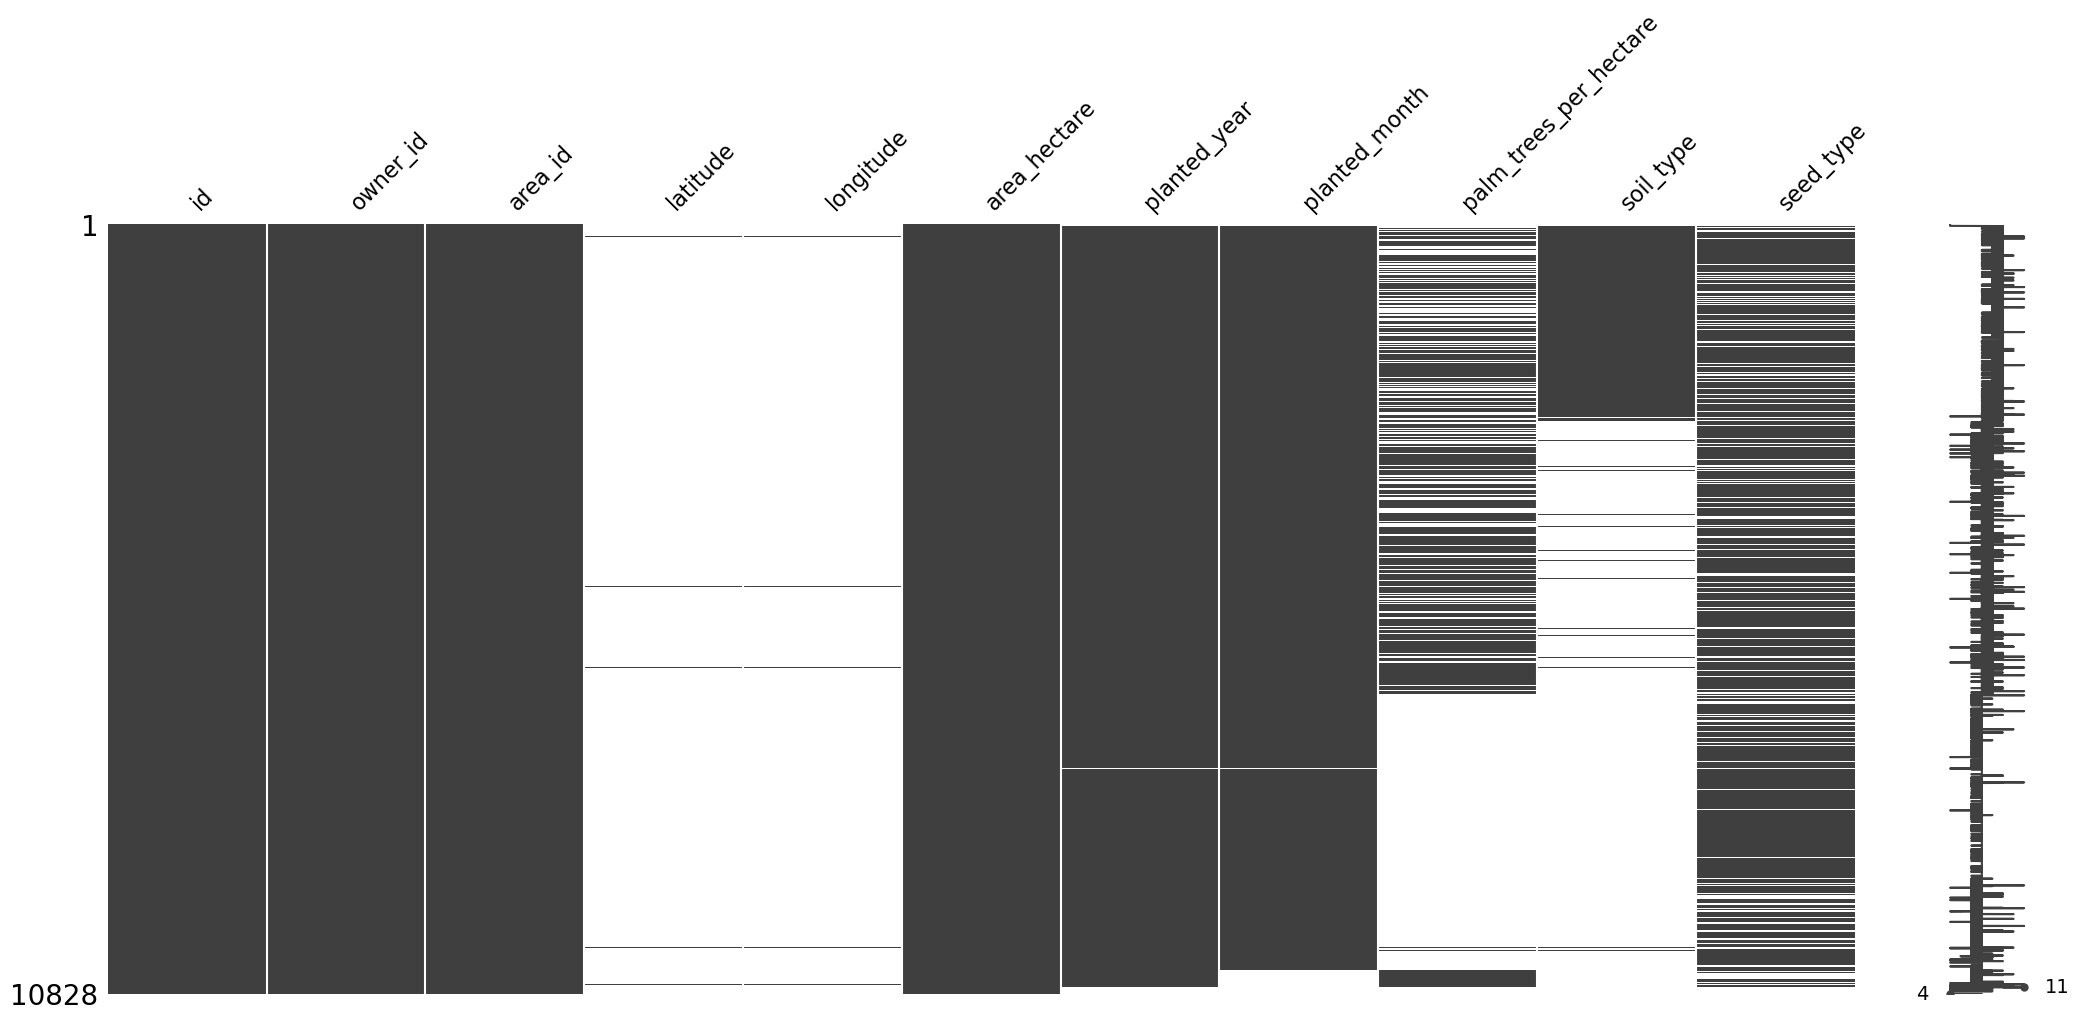

In [430]:
# show which rows contain missing values 
msno.matrix(farm_df)
plt.show()

In [431]:
# show null values in the product_df DataFrame
product_df.isnull().sum()

id                      0
sku                     0
type                    0
name                    0
unit_of_measurement    13
price                   0
description             0
dtype: int64

In [432]:
# show null values in the so_df DataFrame
so_df.isnull().sum()

id                  0
user_id             0
total_item_price    0
created_at_utc0     0
dtype: int64

In [433]:
# show null values in the soi_df DataFrame
soi_df.isnull().sum()

id               0
sale_order_id    0
product_id       0
quantity         0
price            0
dtype: int64

In [434]:
# show null values in the feedback_df DataFrame
feedback_df.isnull().sum()

feedback_id       0
sales_order_id    0
rating            0
comment           0
dtype: int64

In [435]:
# show null values in the product_clicks_df DataFrame
product_clicks_df.isnull().sum()

prodct_clicks_id    0
product_id          0
timestamp           0
dtype: int64

In [436]:
# show null values in the user_session_df DataFrame
user_session_df.isnull().sum()

user_session_id    0
user_id            0
session_start      0
session_end        0
dtype: int64

In [437]:
# show the cardinality of the area_df DataFrame
area_df.nunique()

id                   5794
name                 5794
level_0                 1
level_1                39
level_2               457
level_3              2462
level_3_latitude     2518
level_3_longitude    1997
level_4              5401
level_4_latitude     5782
level_4_longitude    5618
dtype: int64

In [438]:
# show the cardinality of the farm_df DataFrame
farm_df.nunique()

id                        10828
owner_id                   8647
area_id                    5794
latitude                     87
longitude                    87
area_hectare                485
planted_year                 46
planted_month                12
palm_trees_per_hectare      402
soil_type                     4
seed_type                    14
dtype: int64

In [439]:
# show the cardinality of the product_df DataFrame
product_df.nunique()

id                     40
sku                    39
type                    3
name                   39
unit_of_measurement     3
price                  37
description            34
dtype: int64

In [440]:
# show the cardinality of the so_df DataFrame
so_df.nunique()

id                  802
user_id             211
total_item_price    219
created_at_utc0     802
dtype: int64

In [441]:
# show the cardinality of the soi_df DataFrame
soi_df.nunique()

id               812
sale_order_id    802
product_id        40
quantity          91
price             69
dtype: int64

In [442]:
# show the cardinality of the feedback_df DataFrame
feedback_df.nunique()

feedback_id       41
sales_order_id    38
rating             5
comment           41
dtype: int64

In [443]:
# show the cardinality of the product_clicks_df DataFrame
product_clicks_df.nunique()

prodct_clicks_id    41
product_id          41
timestamp           41
dtype: int64

In [444]:
# show the cardinality of the user_session_df DataFrame
user_session_df.nunique()

user_session_id    41
user_id            35
session_start      41
session_end        41
dtype: int64

In [445]:
# check duplicates in the area_df DataFrame
area_df.duplicated().sum()  

0

In [446]:
# check duplicates in the farm_df DataFrame
farm_df.duplicated().sum()  

0

In [447]:
# check duplicates in the product_df DataFrame
product_df.duplicated().sum()

0

In [448]:
# check duplicates in the so_df DataFrame
so_df.duplicated().sum()

0

In [449]:
# check duplicates in the soi_df DataFrame  
soi_df.duplicated().sum()

0

In [450]:
# check duplicates in the feedback_df DataFrame
feedback_df.duplicated().sum()

0

In [451]:
# check duplicates in the product_clicks_df DataFrame
product_clicks_df.duplicated().sum()

0

In [452]:
# check duplicates in the user_session_df DataFrame
user_session_df.duplicated().sum()

0

### There are no duplicated rows for each table.

array([[<Axes: title={'center': 'level_3_latitude'}>,
        <Axes: title={'center': 'level_3_longitude'}>],
       [<Axes: title={'center': 'level_4_latitude'}>,
        <Axes: title={'center': 'level_4_longitude'}>]], dtype=object)

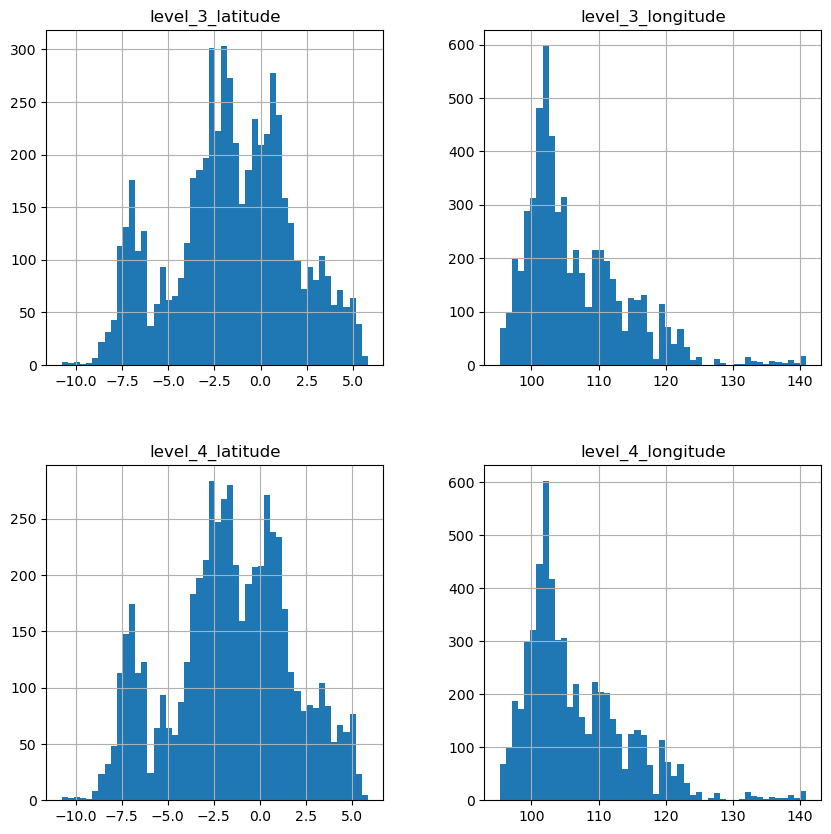

In [453]:
# plot histogram of the area_df DataFrame
area_df.hist(figsize=(10, 10), bins=50)

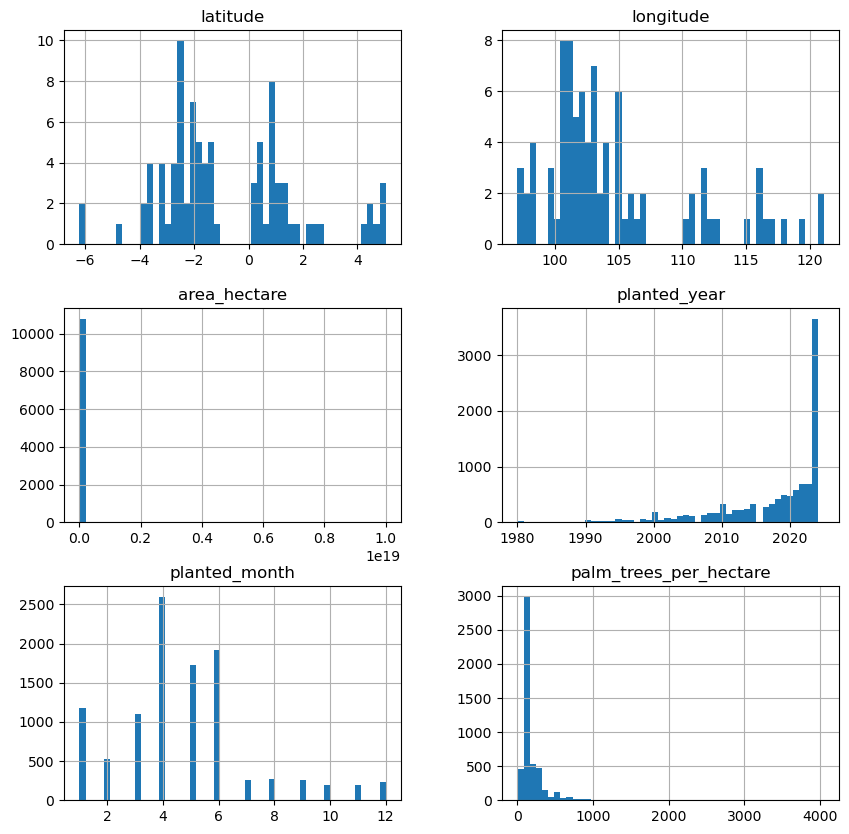

In [454]:
# plot histogram of the farm_df DataFrame
farm_df.hist(figsize=(10, 10), bins=50)
plt.show()

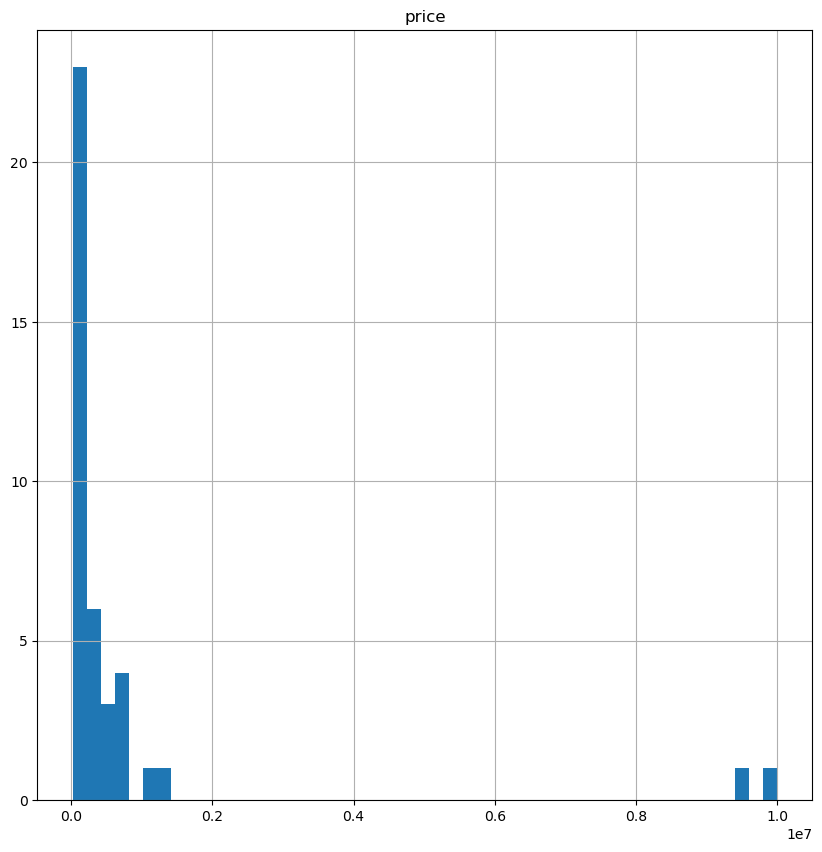

In [455]:
# plot histogram of the product_df DataFrame
product_df.hist(figsize=(10, 10), bins=50)
plt.show()

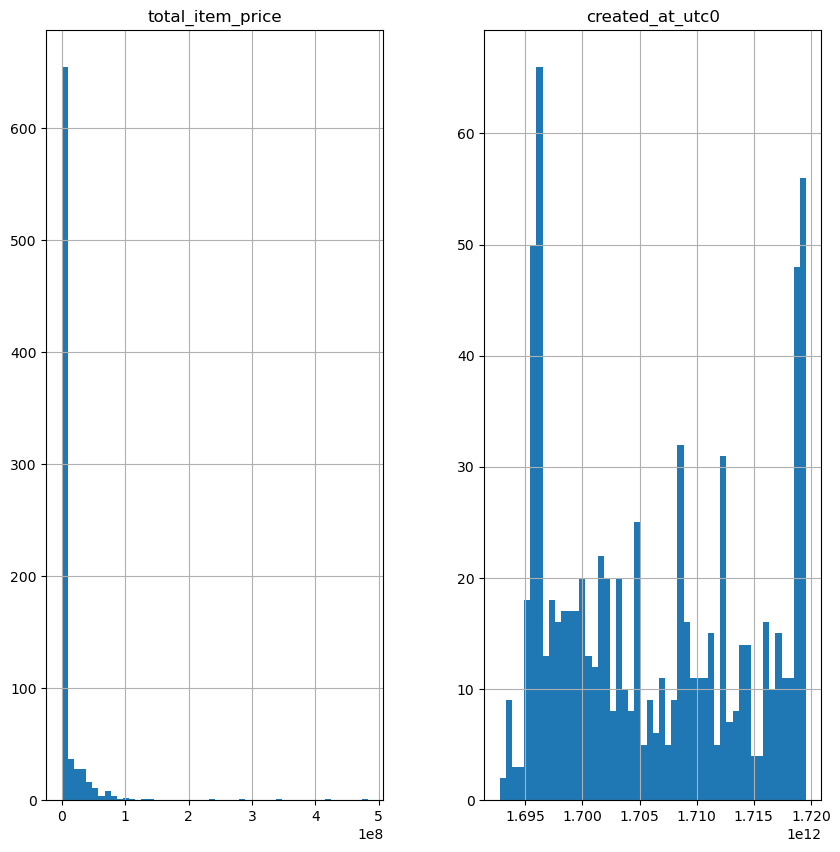

In [456]:
# plot histogram of the so_df DataFrame
so_df.hist(figsize=(10, 10), bins=50)
plt.show()

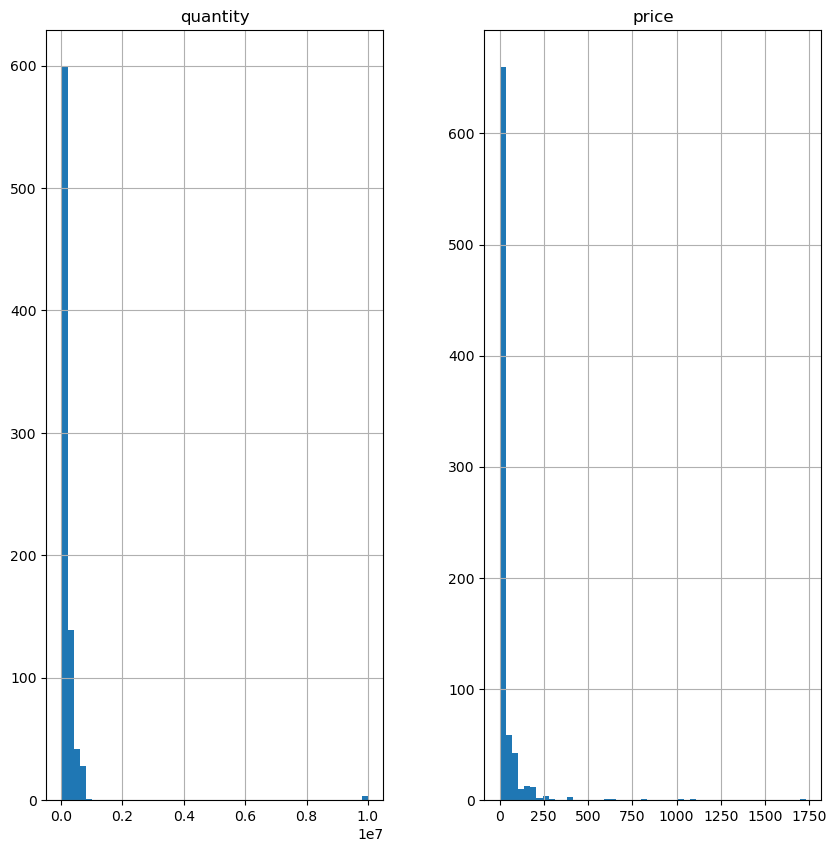

In [457]:
# plot histogram of the soi_df DataFrame
soi_df.hist(figsize=(10, 10), bins=50)
plt.show()

### Renaming of columns for easier interpretability

In [458]:
area_df.columns

Index(['id', 'name', 'level_0', 'level_1', 'level_2', 'level_3',
       'level_3_latitude', 'level_3_longitude', 'level_4', 'level_4_latitude',
       'level_4_longitude'],
      dtype='object')

In [459]:
farm_df.columns

Index(['id', 'owner_id', 'area_id', 'latitude', 'longitude', 'area_hectare',
       'planted_year', 'planted_month', 'palm_trees_per_hectare', 'soil_type',
       'seed_type'],
      dtype='object')

In [460]:
soi_df.columns

Index(['id', 'sale_order_id', 'product_id', 'quantity', 'price'], dtype='object')

In [461]:
so_df.columns

Index(['id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

In [462]:
product_df.columns

Index(['id', 'sku', 'type', 'name', 'unit_of_measurement', 'price',
       'description'],
      dtype='object')

In [463]:
# rename area_df columns
area_df.rename(columns={'id': 'area_id'}, inplace=True)
area_df.columns

Index(['area_id', 'name', 'level_0', 'level_1', 'level_2', 'level_3',
       'level_3_latitude', 'level_3_longitude', 'level_4', 'level_4_latitude',
       'level_4_longitude'],
      dtype='object')

In [464]:
# rename farm_df columns
farm_df.rename(columns={'id': 'farm_id'}, inplace=True)
farm_df.columns

Index(['farm_id', 'owner_id', 'area_id', 'latitude', 'longitude',
       'area_hectare', 'planted_year', 'planted_month',
       'palm_trees_per_hectare', 'soil_type', 'seed_type'],
      dtype='object')

In [465]:
# rename product_df columns
product_df.rename(columns={'id': 'product_id', 'price': 'product_price'}, inplace=True)
product_df.columns

Index(['product_id', 'sku', 'type', 'name', 'unit_of_measurement',
       'product_price', 'description'],
      dtype='object')

In [466]:
# rename soi_df columns
soi_df.rename(columns={'id': 'sale_order_item_id', 'price': 'sale_order_item_price'}, inplace=True)
soi_df.columns

Index(['sale_order_item_id', 'sale_order_id', 'product_id', 'quantity',
       'sale_order_item_price'],
      dtype='object')

In [467]:
# rename so_df columns
so_df.rename(columns={'id': 'sale_order_id'}, inplace=True)
so_df.columns

Index(['sale_order_id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

In [468]:
# Convert from milliseconds to datetime
so_df['created_at'] = pd.to_datetime(so_df['created_at_utc0'], unit='ms')
so_df.head()

,sale_order_id,user_id,total_item_price,created_at_utc0,created_at
0,5efc1940-ffbc-42d5-971c-c371f0f9e4d0,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719571211174,2024-06-28 10:40:11.174
1,8bc2245e-9139-49d2-8dcf-a5bf987f95e6,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719570526244,2024-06-28 10:28:46.244
2,a063780d-98f2-45ce-80b4-4a5dc6c88913,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719570162699,2024-06-28 10:22:42.699
3,fb4edf76-6023-43f0-b7f7-33d60944fcba,a294d318-84f6-4511-b3d6-b3308a25d54a,210000.0,1719570066683,2024-06-28 10:21:06.683
4,f77509f8-af76-4b52-a581-d986af60fab3,bc9cef21-d236-4d71-adb2-ca7b71a5264d,210000.0,1719569546696,2024-06-28 10:12:26.696


In [469]:
# minmax date of created_at
so_df['created_at'].min(), so_df['created_at'].max()

(Timestamp('2023-08-23 02:30:15.859000'),
 Timestamp('2024-06-28 10:40:11.174000'))

### View cardinality of level variables 

In [470]:
# show values for area_df for level variables
area_df['level_1'].value_counts()

level_1
Riau                          791
Sumatera Utara                550
Jambi                         519
Kalimantan Barat              476
Sumatera Selatan              452
Jawa Barat                    364
Aceh                          361
Kalimantan Tengah             259
Kalimantan Timur              218
Bengkulu                      212
Lampung                       208
Sumatera Barat                161
Kalimantan Selatan            147
Jawa Tengah                   140
Jawa Timur                    133
Kepulauan Bangka Belitung     112
Sulawesi Selatan              103
Banten                         73
Sulawesi Tengah                69
Sulawesi Barat                 66
Sulawesi Tenggara              61
Kepulauan Riau                 57
Papua                          32
DKI Jakarta                    31
Kalimantan Utara               28
Nusa Tenggara Timur            26
Papua Barat                    25
Gorontalo                      19
Sulawesi Utara                 18
Nusa T

In [471]:
area_df['level_2'].value_counts()

level_2
Kampar                 119
Musi Banyuasin          93
Ketapang                91
Kuantan Singingi        90
Rokan Hulu              90
                      ... 
Kota Salatiga            1
Kota Surakarta           1
Temanggung               1
Kota Pangkal Pinang      1
Tanah Datar              1
Name: count, Length: 457, dtype: int64

In [472]:
area_df['level_3'].value_counts()

level_3
Tapung            17
Bayung Lencir     15
Pelepat Ilir      14
Muara Bulian      14
Bathin Solapan    13
                  ..
Bonto Bahari       1
Benteng            1
Tatanga            1
Palu Barat         1
Depapre            1
Name: count, Length: 2462, dtype: int64

In [473]:
area_df['level_4'].value_counts()

level_4
Rantau Panjang      9
Sidomulyo           7
Mekar Jaya          6
Suka Maju           6
Suka Makmur         6
                   ..
Bagendang Permai    1
Natai Baru          1
Bagendang Tengah    1
Pelangsian          1
Tablasupa           1
Name: count, Length: 5401, dtype: int64

### Merging of Dataframes

In [474]:
merged_data = soi_df.merge(so_df, on='sale_order_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,user_id,total_item_price,created_at_utc0,created_at
0,c9c618d4-6a87-4fe6-b599-f70a8eb945e5,93b24b37-97df-40dc-9ee6-feb0ec53e3db,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504512120,2024-03-27 01:55:12.120
1,676d47f9-5990-4a92-b6cc-7a6167bc095f,4633e76f-9730-4177-b7d3-7e3f07fceb44,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504602366,2024-03-27 01:56:42.366
2,4b245235-7a25-4025-a61e-d0e6fbbbfc1d,2dacc8ea-6bca-4526-8fb8-cff62bc76cc4,9aab3102-3aee-4639-b7f6-4dd33933c675,100000,1.0,aaf21705-abf9-44c3-94ab-1b5924615f75,100000.0,1696403372827,2023-10-04 07:09:32.827
3,106f766a-3cb2-4ca1-b5de-d23659ce21f8,b8947fb5-9cee-4d1a-bc93-502f1dfd6ca5,6c27fc9c-e7e9-4e9b-9017-292175250df1,260000,100.0,468556ca-994d-40aa-9c44-859d8e445a57,26000000.0,1709877032142,2024-03-08 05:50:32.142
4,502a4281-eb71-4433-9ab9-20995779d8a2,4dfebad3-a88f-4aea-8217-c262b80c1594,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504719927,2024-03-27 01:58:39.927


In [475]:
merged_data = merged_data.merge(product_df, on='product_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,user_id,total_item_price,created_at_utc0,created_at,sku,type,name,unit_of_measurement,product_price,description
0,c9c618d4-6a87-4fe6-b599-f70a8eb945e5,93b24b37-97df-40dc-9ee6-feb0ec53e3db,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504512120,2024-03-27 01:55:12.120,TUP/TKL/100,DIGITAL,Pulsa Telkomsel 100.000,,105000.0,Pulsa Telkomsel 100.000
1,676d47f9-5990-4a92-b6cc-7a6167bc095f,4633e76f-9730-4177-b7d3-7e3f07fceb44,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504602366,2024-03-27 01:56:42.366,TUP/TKL/100,DIGITAL,Pulsa Telkomsel 100.000,,105000.0,Pulsa Telkomsel 100.000
2,4b245235-7a25-4025-a61e-d0e6fbbbfc1d,2dacc8ea-6bca-4526-8fb8-cff62bc76cc4,9aab3102-3aee-4639-b7f6-4dd33933c675,100000,1.0,aaf21705-abf9-44c3-94ab-1b5924615f75,100000.0,1696403372827,2023-10-04 07:09:32.827,AAS/TDS/01,SERVICE,Dokter Sawit Konsultasi,konsultasi,100000.0,"Atasi masalah di kebun sawitmu, Jadwalkan video call sekarang! Atasi masalah di kebun sawitmu, Jadwalkan video call sekarang!"
3,106f766a-3cb2-4ca1-b5de-d23659ce21f8,b8947fb5-9cee-4d1a-bc93-502f1dfd6ca5,6c27fc9c-e7e9-4e9b-9017-292175250df1,260000,100.0,468556ca-994d-40aa-9c44-859d8e445a57,26000000.0,1709877032142,2024-03-08 05:50:32.142,101110603901,GOODS,NPK Phonska Plus 15-15-15 25kg,kg,522500.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.</p><p><br></p><p>Bentuk / Warna: Granul / Putih</p><p><br></p><p><strong><em><u>Manfaat</u></em></strong></p><p><br></p><p>Pupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.</p><p><br></p><p><strong><em><u>Kandungan dan Spesifikasi</u></em></strong></p><p><br></p><p>Nitrogen 15%</p><p>Fosfor pentoksida 15%</p><p>Kalium 15%</p><p>Sulfur 9%</p><p>Zinc 0,2%</p><p><br></p><p><strong><em><u>Produk Teruji Lab?</u></em></strong> Ya</p>"
4,502a4281-eb71-4433-9ab9-20995779d8a2,4dfebad3-a88f-4aea-8217-c262b80c1594,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504719927,2024-03-27 01:58:39.927,TUP/TKL/100,DIGITAL,Pulsa Telkomsel 100.000,,105000.0,Pulsa Telkomsel 100.000


In [476]:
def clean_html(raw_html):
    # Remove HTML tags
    clean_text = re.sub(r'<[^>]+>', '', raw_html)
    # Remove leading/trailing whitespaces and normalize spaces
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Apply to the 'description' column
merged_data['description'] = merged_data['description'].astype(str).apply(clean_html)

# Preview the cleaned descriptions
merged_data[['description']].head()


,description
0,Pulsa Telkomsel 100.000
1,Pulsa Telkomsel 100.000
2,"Atasi masalah di kebun sawitmu, Jadwalkan video call sekarang! Atasi masalah di kebun sawitmu, Jadwalkan video call sekarang!"
3,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 15%Fosfor pentoksida 15%Kalium 15%Sulfur 9%Zinc 0,2%Produk Teruji Lab? Ya"
4,Pulsa Telkomsel 100.000


In [477]:
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,user_id,total_item_price,created_at_utc0,created_at,sku,type,name,unit_of_measurement,product_price,description
0,c9c618d4-6a87-4fe6-b599-f70a8eb945e5,93b24b37-97df-40dc-9ee6-feb0ec53e3db,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504512120,2024-03-27 01:55:12.120,TUP/TKL/100,DIGITAL,Pulsa Telkomsel 100.000,,105000.0,Pulsa Telkomsel 100.000
1,676d47f9-5990-4a92-b6cc-7a6167bc095f,4633e76f-9730-4177-b7d3-7e3f07fceb44,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504602366,2024-03-27 01:56:42.366,TUP/TKL/100,DIGITAL,Pulsa Telkomsel 100.000,,105000.0,Pulsa Telkomsel 100.000
2,4b245235-7a25-4025-a61e-d0e6fbbbfc1d,2dacc8ea-6bca-4526-8fb8-cff62bc76cc4,9aab3102-3aee-4639-b7f6-4dd33933c675,100000,1.0,aaf21705-abf9-44c3-94ab-1b5924615f75,100000.0,1696403372827,2023-10-04 07:09:32.827,AAS/TDS/01,SERVICE,Dokter Sawit Konsultasi,konsultasi,100000.0,"Atasi masalah di kebun sawitmu, Jadwalkan video call sekarang! Atasi masalah di kebun sawitmu, Jadwalkan video call sekarang!"
3,106f766a-3cb2-4ca1-b5de-d23659ce21f8,b8947fb5-9cee-4d1a-bc93-502f1dfd6ca5,6c27fc9c-e7e9-4e9b-9017-292175250df1,260000,100.0,468556ca-994d-40aa-9c44-859d8e445a57,26000000.0,1709877032142,2024-03-08 05:50:32.142,101110603901,GOODS,NPK Phonska Plus 15-15-15 25kg,kg,522500.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 15%Fosfor pentoksida 15%Kalium 15%Sulfur 9%Zinc 0,2%Produk Teruji Lab? Ya"
4,502a4281-eb71-4433-9ab9-20995779d8a2,4dfebad3-a88f-4aea-8217-c262b80c1594,5c3f5704-51bb-4744-a77e-e8488dafbede,103000,1.0,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,103000.0,1711504719927,2024-03-27 01:58:39.927,TUP/TKL/100,DIGITAL,Pulsa Telkomsel 100.000,,105000.0,Pulsa Telkomsel 100.000


In [478]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sale_order_item_id     812 non-null    object        
 1   sale_order_id          812 non-null    object        
 2   product_id             812 non-null    object        
 3   quantity               812 non-null    int64         
 4   sale_order_item_price  812 non-null    float64       
 5   user_id                812 non-null    object        
 6   total_item_price       812 non-null    float64       
 7   created_at_utc0        812 non-null    int64         
 8   created_at             812 non-null    datetime64[ns]
 9   sku                    812 non-null    object        
 10  type                   812 non-null    object        
 11  name                   812 non-null    object        
 12  unit_of_measurement    575 non-null    object        
 13  produ

In [479]:
# Count number of unique products purchased per user
top_users_unique_products = merged_data.groupby('user_id')['product_id'].nunique().sort_values(ascending=False).head(10)

# Display the result
print("Top 10 Users by Number of Unique Products Purchased:")
print(top_users_unique_products)

Top 10 Users by Number of Unique Products Purchased:
user_id
468556ca-994d-40aa-9c44-859d8e445a57    14
8c0784de-fc31-4b3e-aa03-b93961427d46    11
3343ce0b-c263-4b8b-8bf9-783c1b360c41     7
7a341d40-7166-46d4-b37f-be9a9ecec7f7     7
eb5f944b-fb6a-4053-b583-83ac0c019501     6
05d2056f-a36d-49dd-813b-b093ec673451     6
0600fab5-173c-4333-b3c3-c18b37148acf     6
a2514c7a-01b5-4ddf-a61e-1c3d2f32e13e     6
1dcb61f2-9802-4294-a697-7197c64fbcf6     6
cbe2cbf8-4c69-4a15-9f37-bf774beec72b     6
Name: product_id, dtype: int64


In [480]:
# # extract top 15 users by number of unique products purchased to csv
# top_users_unique_products.to_csv('top_10_users_unique_products.csv', header=True)

In [481]:
# Count number of unique users who purchased each product
top_products_by_users = merged_data.groupby('product_id')['user_id'].nunique().sort_values(ascending=False).head(10)

# Display the result with product names
print("Top 10 Products by Number of Unique Users:")
for product_id, user_count in top_products_by_users.items():
    product_name = merged_data[merged_data['product_id'] == product_id]['name'].iloc[0]
    print(f"{product_name} (ID: {product_id}): {user_count} unique users")

Top 10 Products by Number of Unique Users:
Minyak Goreng Harumas 1 liter (ID: ae250a61-1ab7-48a1-a59e-3f9863fe830b): 48 unique users
Dokter Sawit Konsultasi (ID: a833067e-e467-4c57-b702-e1a0d1458b77): 35 unique users
Pulsa Telkomsel 100.000 (ID: 5c3f5704-51bb-4744-a77e-e8488dafbede): 28 unique users
Minyak Goreng Camar 1 liter - Ramadhan Berkah (ID: 88888e1c-9ac5-43b8-8204-418560b5c686): 23 unique users
Urea Pusri NS 50 50kg (ID: 96329d75-9cb4-4991-8467-8ea1e0e024d3): 19 unique users
MOP/KCL Canada Cap Mahkota 50kg (ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd): 18 unique users
Dokter Sawit Konsultasi (ID: 9aab3102-3aee-4639-b7f6-4dd33933c675): 15 unique users
Pulsa Telkomsel 50.000 (ID: f04792d1-5989-4877-b31f-c08411017c64): 14 unique users
Token PLN 200.000 (ID: c7768e6d-d8d9-469f-960d-879b5401d83c): 13 unique users
Token PLN 100.000 (ID: 5952d124-7dc6-4a6a-baa2-e2e502ecd6fe): 13 unique users


In [482]:
# # extract top 10 products by number of unique users to csv
# top_products_by_users.to_csv('top_10_products_by_users.csv', header=True)

# Recommendation System for user_id API 

## Hybrid approach (User-based Collaborative Filtering + Seasonality Filtering)

In [483]:
# Create user-product matrix
user_product_matrix = merged_data.pivot_table(index='user_id', columns='product_id', values='quantity', fill_value=0)

# Matrix factorization using TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=42)
matrix_svd = svd.fit_transform(user_product_matrix)
print(svd.explained_variance_ratio_.sum())

# Compute cosine similarity between users
user_similarity = cosine_similarity(matrix_svd)

# Create a DataFrame of similarities
user_similarity_df = pd.DataFrame(user_similarity, index=user_product_matrix.index, columns=user_product_matrix.index)
user_similarity_df.head()

0.993451890963798


user_id,01a28604-081b-4698-b098-f8b1d87488ea,024e2c35-b21c-49bd-998f-ed3a0448b4f6,024ec4bd-18ab-491a-9c2a-8fd3272fb93d,0444d769-9c40-45c9-96d9-1a711e600df7,04fc8f61-fe05-43b0-b8c7-37c254bf40d8,05d2056f-a36d-49dd-813b-b093ec673451,0600fab5-173c-4333-b3c3-c18b37148acf,069e4b0c-02d2-41c5-8453-93c28d665884,095f8725-d498-11ee-9590-42010a400002,09cbd6f1-aa1c-4686-ba90-2c25801fbd94,09eeeac4-3ccc-4906-b261-e7d37f6465f1,0c422058-301f-45b0-816d-12198677b7e4,0c4e0840-eb90-4863-8862-957a425e8944,0c52632e-4b46-4b5f-8ff7-39ae71e68b52,0e86be98-b23d-4a97-91ac-d0d951e48547,10a06392-5870-4257-8077-da1a19ffd0b7,14d3b88b-3aeb-4873-ae24-53858a83c2b3,164b917b-4b2d-49ca-b044-31428b6fd5b7,16854ca7-be83-4d89-9285-13c478f20e2d,16990165-c39a-468b-9075-09fadbe777a3,17f6a9f1-c49c-4451-9d53-d72fd1ae21a3,183a552e-07c0-4c93-a866-d0ef6b68d003,187f23dd-3187-49c5-8e75-e542484f9067,194e3b1b-1d15-44c0-a9f3-772283654532,1a1f4552-1ba1-4f03-b4b2-07bbb749573e,1c3c1c63-b993-47b6-a985-b111d1f0abf7,1dcb61f2-9802-4294-a697-7197c64fbcf6,1e23c020-b65c-4d4f-8fd5-a61c43d7167b,1f533c2b-4017-4a4e-86ce-15d06303c57e,2086cdc7-d8dd-4e3d-8f64-a04dba7a9819,21b558cc-8a25-4023-a1fd-74836a029cda,21eb6b7c-fa46-49b0-a77e-90533b140ce8,21ec3a60-8f2b-410e-95da-ad8d67b8c8ad,2291847c-b0c4-4223-95de-ec295c34b574,24c4a7f2-8d01-4d37-b540-71f8d50063e9,257dd0a5-609a-4be4-8f09-0a1026f4c471,268d7d1d-39b5-4db4-b657-4027329558ff,26f4c279-88c9-43b3-ab94-77c49f461528,275c4ffb-3c8b-4624-9e4d-5ee29de1462e,29bdaaca-c830-4f96-97ba-1655998b7c71,2a9174aa-e1b7-4387-bce0-3546eb594587,311123a2-fd09-489e-b622-bf8a6bd64177,31c24872-6327-41f1-ba55-990278034ea0,3343ce0b-c263-4b8b-8bf9-783c1b360c41,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,3450bf21-8c45-46ee-999f-64fbfdcc2fe0,352dd086-ba25-4549-bdaa-5428f26f5b43,380ec807-c59e-4bf0-9458-5fbc6b33af7e,3821d1bb-b34a-4412-b46d-78648ce12966,38d78ce3-b27c-4011-a9be-2b8bd2276697,38f0463f-31a8-4e2e-9ea9-71134e169a2d,3aaa6841-de2e-4f97-9ab5-54598ca43dbc,3d45dbe9-ed3b-42bd-89b0-55beb05f57bf,3dd4849f-3479-4123-a378-60dd8ca58c83,3fc636dd-17a7-4f96-b7e6-c551c4b48889,41953817-556b-4235-b912-79add6cb9958,431070d8-73d3-46f0-b1e9-0ee6a7dc5244,43c40fab-f866-4c5f-a11a-7ec6d9ec301b,4492efe4-068d-4047-b025-36df68ecbbe0,44d8f734-b74b-4922-b438-492f6fd015c1,4547e388-0e43-406b-97de-6876c37b64b6,468556ca-994d-40aa-9c44-859d8e445a57,46d348fe-a696-444e-9f47-e040cf20b361,47049bfe-4a3c-4fd8-a36a-aa2aeaf7882c,49bb52c7-3560-4183-9fce-41572708300d,4aa94241-d621-48fa-8473-29eb0828c971,4c56de79-c774-468b-af4c-3e556cd852f3,4c787d25-c3d2-4471-83e8-76ba3809ac3d,4cc7a537-fded-44c2-aef9-f1e7cfa42fdf,4eea506a-67ab-4bb3-ac49-5a9912ad0589,549d11f9-13b6-4815-800c-0a6af7389d20,56660a2a-5b21-4b64-8162-eaca7e36bf3c,56ca89ee-80dc-44b1-aba7-55ec5bca0037,580a2221-208e-4cbe-8b30-4f88b4424efd,58e1a1a1-17a2-4517-9e21-3e9c81df8fe7,58e374a9-e233-43a1-ab5d-50bd27060144,58fa09a4-4419-4830-8de6-2df422ecd950,59014657-3b4d-49ac-a025-75e42979dc45,5a548acd-dcd9-4093-9ef9-3b8a1ada7ce4,5dd481ec-bcfc-44fe-8dfa-ca993a7b5be4,5edfe1ab-a4c0-4334-97f9-08910c035ba9,639fb12d-80c4-4029-9113-fc81a7765c95,64edd050-48f5-4886-b94f-b1413fe236c8,6608741a-3352-43ed-95fb-f985ba053ae7,697c5650-3f19-4729-8273-51deb7de128f,6a12c8d7-f647-4aee-a118-22284df49702,6a59f0dc-8db9-43d3-8c9d-545338d923a5,6a82bdea-eb4d-45e9-8ec9-33651afe2dd8,6ba0b5b6-eb3f-496d-8406-f6ebb131d878,6bbbba20-19c9-4484-9a1c-30736e14ccd9,6c43e59e-949f-4f6b-9d20-9929e3067f51,6c6a7d96-efee-4e00-bc42-37c4b166852f,6e07bb73-25be-4ff8-bcc5-fcdbc478f790,7421b833-063a-44cd-b0ef-24b776735d40,75f66f80-21fd-4de4-a1a9-80f226160528,7810b127-5a6f-4b4c-96d7-2ac786b24a13,79094903-609b-408d-831f-1f0a0a9cbacb,79934ca3-538f-4c22-8a18-d7be3e3d39c6,7a341d40-7166-46d4-b37f-be9a9ecec7f7,8146b11a-aa88-4689-bcfb-b1e0e6621d04,81b1b78c-0294-4e36-a171-a37631b46693,81fc73a1-2c1a-4181-9a0e-9f2c997f4e8c,82656e75-6449-438c-9252-0cd760913acb,83a22f34-8b3a-43a3-a9fd-e7f1da140467,83c418ed-9eee-4ad9-b1a0-f20293b19034,842fb743-c2c6-48ee-ad9c-2e590cef76a0,861fc764-f655-490f-9ff1-b884a9779973,8624159f-c2b1-4d55-a6fc-72cf7a3a4

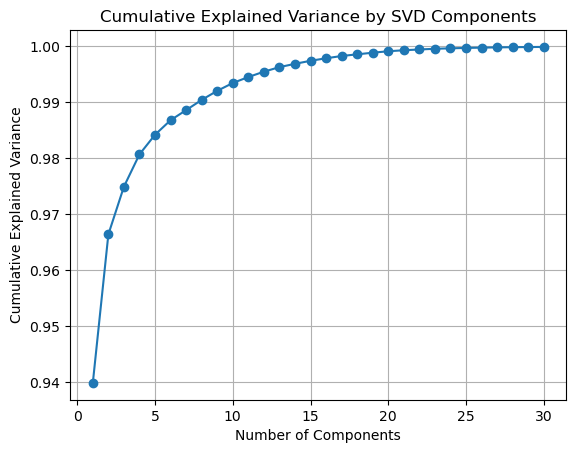

In [484]:
svd = TruncatedSVD(n_components=30)
svd.fit(user_product_matrix)

plt.plot(range(1, 31), svd.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


The curve shows that over 95% of the variance is captured within the first 2-3 components, making them sufficient for efficient dimensionality reduction in user-product recommendations.

In [485]:
def recommend_products(user_id, user_product_matrix, user_similarity_df, top_n=10, top_k_users=10):
    # Identify the most similar users to the target user based on cosine similarity
    top_similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_k_users + 1]

    # Show the top similar users and their cosine similarity scores
    print(f"\nTop {top_k_users} users similar to {user_id} (cosine similarity shown):")
    for uid, similarity in top_similar_users.items():
        print(f"  • User: {uid} — Cosine Similarity: {similarity:.4f}")

    # Get the list of products the target user has already purchased
    user_purchases = user_product_matrix.loc[user_id]
    purchased_product_ids = user_purchases[user_purchases > 0].index.tolist()

    # Accumulate similarity scores for candidate products from similar users
    candidate_scores = {}
    for sim_user_id, similarity in top_similar_users.items():
        sim_user_products = user_product_matrix.loc[sim_user_id]
        for product_id, qty in sim_user_products.items():
            if qty > 0 and product_id not in purchased_product_ids:
                if product_id not in candidate_scores:
                    candidate_scores[product_id] = []
                candidate_scores[product_id].append(similarity) # Accumulate similarity from each recommender

    # Compute total cosine similarity score for each candidate product and sort
    ranked_products = sorted(
        {pid: sum(scores) for pid, scores in candidate_scores.items()}.items(),
        key=lambda x: x[1],
        reverse=True
    )[:top_n] # Get top N recommended products with the highest summed similarity

    # Print products the user has already bought
    print(f"\nProducts already bought by user {user_id}:")
    product_names = [
        merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        if not merged_data[merged_data['product_id'] == pid]['name'].empty else "Unknown"
        for pid in purchased_product_ids
    ]
    print('  ' + ', '.join(product_names) if product_names else "  No purchases found.")

    # Show purchases made by similar users
    print(f"\nProducts bought by similar users (not necessarily recommended):")
    for uid in top_similar_users.index:
        sim_purchases = user_product_matrix.loc[uid][user_product_matrix.loc[uid] > 0].index.tolist()
        sim_product_names = [
            merged_data[merged_data['product_id'] == pid]['name'].iloc[0] 
            for pid in sim_purchases
        ]
        print(f"  • User {uid} bought: {', '.join(sim_product_names)}")

    # Print top N recommended products for the user
    print(f"\nTop {top_n} recommended products for user {user_id}:\n")
    for i, (pid, _) in enumerate(ranked_products, start=1):
        name = merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        print(f"  {i}. {name}")

    return ranked_products, top_similar_users

# Example usage
user_id = 'a294d318-84f6-4511-b3d6-b3308a25d54a'
recommendations, similar_users = recommend_products(user_id, user_product_matrix, user_similarity_df)



Top 10 users similar to a294d318-84f6-4511-b3d6-b3308a25d54a (cosine similarity shown):
  • User: 8624159f-c2b1-4d55-a6fc-72cf7a3a4a1f — Cosine Similarity: 1.0000
  • User: 5dd481ec-bcfc-44fe-8dfa-ca993a7b5be4 — Cosine Similarity: 1.0000
  • User: bc9cef21-d236-4d71-adb2-ca7b71a5264d — Cosine Similarity: 0.9999
  • User: 75f66f80-21fd-4de4-a1a9-80f226160528 — Cosine Similarity: 0.9999
  • User: 8c89bfd1-64bf-484a-9860-bab339f48261 — Cosine Similarity: 0.9999
  • User: 8146b11a-aa88-4689-bcfb-b1e0e6621d04 — Cosine Similarity: 0.9998
  • User: 639fb12d-80c4-4029-9113-fc81a7765c95 — Cosine Similarity: 0.9991
  • User: 21b558cc-8a25-4023-a1fd-74836a029cda — Cosine Similarity: 0.9922
  • User: 6a82bdea-eb4d-45e9-8ec9-33651afe2dd8 — Cosine Similarity: 0.9922
  • User: fcea14e7-ddd2-4765-9d88-ec9828614cf1 — Cosine Similarity: 0.9922

Products already bought by user a294d318-84f6-4511-b3d6-b3308a25d54a:
  Token PLN 200.000

Products bought by similar users (not necessarily recommended):
  • U

I used the sum of cosine similarity because it reflects both how close other users are to the target user and how many of those similar users bought the product. This makes it a simple and effective way to rank recommendations.

* A higher similarity score means the user has more in common with the target user. If a highly similar user bought a product, that’s a strong hint it could be a good fit. In other words, I am giving more weight to people whose taste is closer to the target user’s.

* When more similar users have bought the same product, it adds confidence that the product is worth recommending. It is not just one person’s choice as it shows that several people with similar preferences liked it too.

In [486]:
# Create user-product matrix
user_product_matrix = merged_data.pivot_table(index='user_id', columns='product_id', values='quantity', fill_value=0)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_product_matrix)

# Create a DataFrame of similarities
user_similarity_df = pd.DataFrame(user_similarity, index=user_product_matrix.index, columns=user_product_matrix.index)
user_similarity_df.head()

def recommend_products(user_id, user_product_matrix, user_similarity_df, top_n=10, top_k_users=10):
    # Identify the most similar users to the target user based on cosine similarity
    top_similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_k_users + 1]

    # Show the top similar users and their cosine similarity scores
    print(f"\nTop {top_k_users} users similar to {user_id} (cosine similarity shown):")
    for uid, similarity in top_similar_users.items():
        print(f"  • User: {uid} — Cosine Similarity: {similarity:.4f}")

    # Get the list of products the target user has already purchased
    user_purchases = user_product_matrix.loc[user_id]
    purchased_product_ids = user_purchases[user_purchases > 0].index.tolist()

    # Accumulate similarity scores for candidate products from similar users
    candidate_scores = {}
    for sim_user_id, similarity in top_similar_users.items():
        sim_user_products = user_product_matrix.loc[sim_user_id]
        for product_id, qty in sim_user_products.items():
            if qty > 0 and product_id not in purchased_product_ids:
                if product_id not in candidate_scores:
                    candidate_scores[product_id] = []
                candidate_scores[product_id].append(similarity) # Accumulate similarity from each recommender

    # Compute total cosine similarity score for each candidate product and sort
    ranked_products = sorted(
        {pid: sum(scores) for pid, scores in candidate_scores.items()}.items(),
        key=lambda x: x[1],
        reverse=True
    )[:top_n] # Get top N recommended products with the highest summed similarity

    # Print products the user has already bought
    print(f"\nProducts already bought by user {user_id}:")
    product_names = [
        merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        if not merged_data[merged_data['product_id'] == pid]['name'].empty else "Unknown"
        for pid in purchased_product_ids
    ]
    print('  ' + ', '.join(product_names) if product_names else "  No purchases found.")

    # Show purchases made by similar users
    print(f"\nProducts bought by similar users (not necessarily recommended):")
    for uid in top_similar_users.index:
        sim_purchases = user_product_matrix.loc[uid][user_product_matrix.loc[uid] > 0].index.tolist()
        sim_product_names = [
            merged_data[merged_data['product_id'] == pid]['name'].iloc[0] 
            for pid in sim_purchases
        ]
        print(f"  • User {uid} bought: {', '.join(sim_product_names)}")

    # Print top N recommended products for the user
    print(f"\nTop {top_n} recommended products for user {user_id}:\n")
    for i, (pid, _) in enumerate(ranked_products, start=1):
        name = merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        print(f"  {i}. {name}")

    return ranked_products, top_similar_users

# Example usage
user_id = 'a294d318-84f6-4511-b3d6-b3308a25d54a'
recommendations, similar_users = recommend_products(user_id, user_product_matrix, user_similarity_df)



Top 10 users similar to a294d318-84f6-4511-b3d6-b3308a25d54a (cosine similarity shown):
  • User: 8624159f-c2b1-4d55-a6fc-72cf7a3a4a1f — Cosine Similarity: 1.0000
  • User: a294d318-84f6-4511-b3d6-b3308a25d54a — Cosine Similarity: 1.0000
  • User: bc9cef21-d236-4d71-adb2-ca7b71a5264d — Cosine Similarity: 0.8947
  • User: 8c89bfd1-64bf-484a-9860-bab339f48261 — Cosine Similarity: 0.8918
  • User: 75f66f80-21fd-4de4-a1a9-80f226160528 — Cosine Similarity: 0.8918
  • User: 8146b11a-aa88-4689-bcfb-b1e0e6621d04 — Cosine Similarity: 0.8685
  • User: 639fb12d-80c4-4029-9113-fc81a7765c95 — Cosine Similarity: 0.8450
  • User: 24c4a7f2-8d01-4d37-b540-71f8d50063e9 — Cosine Similarity: 0.7917
  • User: bf86a956-b473-4bdd-995b-296b92ea5a7a — Cosine Similarity: 0.7401
  • User: 96f34de1-9fbc-42c6-825e-d25751b52c1c — Cosine Similarity: 0.6965

Products already bought by user a294d318-84f6-4511-b3d6-b3308a25d54a:
  Token PLN 200.000

Products bought by similar users (not necessarily recommended):
  • U

In [487]:
def recommend_products(user_id, user_product_matrix, user_similarity_df, merged_data, top_n=10, top_k_users=10):
    # Identify top K similar users (excluding the user itself)
    top_similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_k_users + 1]

    print(f"\nTop {top_k_users} users similar to {user_id} (cosine similarity shown):")
    for uid, similarity in top_similar_users.items():
        print(f"  • User: {uid} — Cosine Similarity: {similarity:.4f}")

    # Get products already purchased by the user
    user_purchases = user_product_matrix.loc[user_id]
    purchased_product_ids = user_purchases[user_purchases > 0].index.tolist()

    # Map each candidate product to its maximum similarity score (pure similarity)
    product_similarity = {}
    for sim_user_id, similarity in top_similar_users.items():
        sim_user_products = user_product_matrix.loc[sim_user_id]
        for product_id, qty in sim_user_products.items():
            if qty > 0 and product_id not in purchased_product_ids:
                if product_id not in product_similarity or similarity > product_similarity[product_id]:
                    product_similarity[product_id] = similarity

    # Sort products by highest similarity score
    ranked_products = sorted(product_similarity.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Print already purchased products
    print(f"\nProducts already bought by user {user_id}:")
    product_names = [
        merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        if not merged_data[merged_data['product_id'] == pid]['name'].empty else "Unknown"
        for pid in purchased_product_ids
    ]
    print('  ' + ', '.join(product_names) if product_names else "  No purchases found.")

    # Show products bought by similar users
    print(f"\nProducts bought by similar users (not necessarily recommended):")
    for uid in top_similar_users.index:
        sim_purchases = user_product_matrix.loc[uid][user_product_matrix.loc[uid] > 0].index.tolist()
        sim_product_names = [
            merged_data[merged_data['product_id'] == pid]['name'].iloc[0] 
            for pid in sim_purchases
        ]
        print(f"  • User {uid} bought: {', '.join(sim_product_names)}")

    # Print top N recommended products
    print(f"\nTop {top_n} recommended products for user {user_id}:\n")
    for i, (pid, sim_score) in enumerate(ranked_products, start=1):
        name = merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        print(f"  {i}. {name} (similarity: {sim_score:.4f})")

    return ranked_products, top_similar_users

# Example usage
user_id = 'a294d318-84f6-4511-b3d6-b3308a25d54a'
recommendations, similar_users = recommend_products(user_id, user_product_matrix, user_similarity_df,merged_data)


Top 10 users similar to a294d318-84f6-4511-b3d6-b3308a25d54a (cosine similarity shown):
  • User: 8624159f-c2b1-4d55-a6fc-72cf7a3a4a1f — Cosine Similarity: 1.0000
  • User: a294d318-84f6-4511-b3d6-b3308a25d54a — Cosine Similarity: 1.0000
  • User: bc9cef21-d236-4d71-adb2-ca7b71a5264d — Cosine Similarity: 0.8947
  • User: 8c89bfd1-64bf-484a-9860-bab339f48261 — Cosine Similarity: 0.8918
  • User: 75f66f80-21fd-4de4-a1a9-80f226160528 — Cosine Similarity: 0.8918
  • User: 8146b11a-aa88-4689-bcfb-b1e0e6621d04 — Cosine Similarity: 0.8685
  • User: 639fb12d-80c4-4029-9113-fc81a7765c95 — Cosine Similarity: 0.8450
  • User: 24c4a7f2-8d01-4d37-b540-71f8d50063e9 — Cosine Similarity: 0.7917
  • User: bf86a956-b473-4bdd-995b-296b92ea5a7a — Cosine Similarity: 0.7401
  • User: 96f34de1-9fbc-42c6-825e-d25751b52c1c — Cosine Similarity: 0.6965

Products already bought by user a294d318-84f6-4511-b3d6-b3308a25d54a:
  Token PLN 200.000

Products bought by similar users (not necessarily recommended):
  • U

Specificity matters - Farming needs are location/condition specific
Quality over quantity - Better to recommend fewer, highly relevant products
Trust factor - Recommendations from highly similar farmers are more trustworthy
Avoid popularity bias - Prevents common products from dominating recommendations

In [488]:
# Extract month from 'created_at' and add it as a new column
merged_data['month'] = merged_data['created_at'].dt.month

# Monthly quantity per product
monthly_qty = (
    merged_data.groupby(['product_id', 'month'])['quantity']
    .sum()
    .reset_index(name='monthly_quantity')
)

# Total annual quantity per product
annual_qty = (
    merged_data.groupby('product_id')['quantity']
    .sum()
    .reset_index(name='annual_quantity')
)

# Merge total into monthly
monthly_qty = monthly_qty.merge(annual_qty, on='product_id')

# Calculate MR for each month
def calc_mr(df):
    def wrap_month(m):
        return (m - 1) % 12 + 1
    
    results = []
    for pid in df['product_id'].unique():
        prod_df = df[df['product_id'] == pid]
        annual = prod_df['annual_quantity'].iloc[0]
        
        for month in range(1, 13):
            prev_m = wrap_month(month - 1)
            next_m = wrap_month(month + 1)
            
            qty = prod_df.loc[prod_df['month'] == month, 'monthly_quantity'].sum()
            qty += prod_df.loc[prod_df['month'] == prev_m, 'monthly_quantity'].sum()
            qty += prod_df.loc[prod_df['month'] == next_m, 'monthly_quantity'].sum()
            
            mr = qty / annual if annual > 0 else 0
            results.append({'product_id': pid, 'month': month, 'MR': mr, 'annual_quantity': annual})
    return pd.DataFrame(results)

mr_df = calc_mr(monthly_qty)

# Apply thresholds
MOR = 100000  # minimum order threshold
RT = 0.1  # ratio threshold

mr_df['is_low_season'] = (mr_df['annual_quantity'] >= MOR) & (mr_df['MR'] < RT)

# Final table: product_id | month | MR | annual_quantity | is_low_season
seasonal_flag_table = mr_df[['product_id', 'month', 'MR', 'annual_quantity', 'is_low_season']]
seasonal_flag_table.head(30)


,product_id,month,MR,annual_quantity,is_low_season
0,033ec187-4af1-4143-bc64-8c258f4fbd84,1,0.000000,1118000,True
1,033ec187-4af1-4143-bc64-8c258f4fbd84,2,0.189624,1118000,False
2,033ec187-4af1-4143-bc64-8c258f4fbd84,3,0.521467,1118000,False
3,033ec187-4af1-4143-bc64-8c258f4fbd84,4,0.805903,1118000,False
4,033ec187-4af1-4143-bc64-8c258f4fbd84,5,0.810376,1118000,False
5,033ec187-4af1-4143-bc64-8c258f4fbd84,6,0.478533,1118000,False
6,033ec187-4af1-4143-bc64-8c258f4fbd84,7,0.194097,1118000,False
7,033ec187-4af1-4143-bc64-8c258f4fbd84,8,0.000000,1118000,True
8,033ec187-4af1-4143-bc64-8c258f4fbd84,9,0.000000,1118000,True
9,033ec187-4af1-4143-bc64-8c258f4fbd84,10,0.000000,1118000,True


In [489]:
# Select unique product_id-name pairs to avoid duplication during merge
product_names = merged_data[['product_id', 'name']].drop_duplicates()

# Merge annual quantity data with product names
annual_qty_named = annual_qty.merge(product_names, on='product_id', how='left')

# View the top 40 rows
annual_qty_named.head(40)


,product_id,annual_quantity,name
0,033ec187-4af1-4143-bc64-8c258f4fbd84,1118000,Token PLN 50.000
1,1033503b-8faa-4d5c-97c2-50bb19fbb897,15141000,TSP China Cap Daun 50kg
2,1591772e-4f22-4644-97e5-fb38311776f9,1875000,MOP/KCL Cap Daun 50kg
3,1af0394e-3aea-42b4-8698-b6832e35f8ce,2812000,Petro ZA Plus 50kg
4,234a0d4e-b200-4c53-81a7-fc0161679874,1678000,Pulsa Telkomsel 150.000
5,2b8a0a07-dc55-4595-ac97-c21211781344,1100000,Kupon Belanja 100.000
6,39e21352-de56-4ff4-9d40-ee984efceacb,5000000,Kupon Belanja 500.000
7,3c5916df-f2c4-43d0-a693-83806c14fc9c,950000,Benih Sawit Topaz 1-3 Seri 4 (100 butir)
8,46388963-6db5-4efd-b04b-1b88970cc97f,19615000,NPK Mutiara 16-16-16 50kg
9,4770a993-5aa3-4186-a41e-f39d7541df51,240000,Kaos Agen Inovasi SawitPRO size L


In [490]:
from datetime import datetime

def recommend_products_with_seasonal_rollback(user_id, user_product_matrix, user_similarity_df, merged_data,
                                               seasonal_flag_table, top_n=10, top_k_users=10, current_month=None):
    if current_month is None:
        current_month = datetime.now().month

    # Filter seasonal data for current month and rank by MR
    current_seasonality = seasonal_flag_table[seasonal_flag_table['month'] == current_month]
    mr_ranked = current_seasonality.sort_values(by='MR', ascending=False)

    # Identify top K similar users (excluding the user itself)
    top_similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_k_users + 1]

    # Get products already purchased by the user
    user_purchases = user_product_matrix.loc[user_id]
    purchased_product_ids = set(user_purchases[user_purchases > 0].index.tolist())

    # Collect products bought by similar users (excluding those already purchased)
    recommended_scores = {}
    for sim_user_id, similarity in top_similar_users.items():
        sim_user_products = user_product_matrix.loc[sim_user_id]
        for product_id, qty in sim_user_products.items():
            if qty > 0 and product_id not in purchased_product_ids:
                if product_id not in recommended_scores or similarity > recommended_scores[product_id]:
                    recommended_scores[product_id] = similarity

    # Sort recommended products by similarity (pure)
    sorted_recommendations = sorted(recommended_scores.items(), key=lambda x: x[1], reverse=True)
    final_recommendations = sorted_recommendations[:top_n]
    recommended_ids = {pid for pid, _ in final_recommendations}

    # If less than top_n, fill in with seasonal products
    if len(final_recommendations) < top_n:
        needed = top_n - len(final_recommendations)
        fallback_products = [
            (row['product_id'], 0.0) for _, row in mr_ranked.iterrows()
            if row['product_id'] not in purchased_product_ids and row['product_id'] not in recommended_ids
        ][:needed]
        final_recommendations.extend(fallback_products)

    # Print final output
    print(f"\nProducts already bought by user {user_id}:")
    bought_names = [
        merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        if not merged_data[merged_data['product_id'] == pid]['name'].empty else "Unknown"
        for pid in purchased_product_ids
    ]
    print('  ' + ', '.join(bought_names) if bought_names else "  No purchases found.")

    print(f"\nTop {top_n} recommended products for user {user_id}:")
    for i, (pid, score) in enumerate(final_recommendations, start=1):
        name = merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        
        # Lookup MR for current month
        mr_row = seasonal_flag_table[
            (seasonal_flag_table['product_id'] == pid) &
            (seasonal_flag_table['month'] == current_month)
        ]
        mr_display = f"MR: {mr_row['MR'].iloc[0]:.3f}" if not mr_row.empty else "MR: N/A"

        if score == 0.0:
            tag = f"Seasonal Fallback ({mr_display})"
        else:
            tag = f"(similarity: {score:.4f}, {mr_display})"
            
        print(f"  {i}. {name} {tag}")

    return final_recommendations, top_similar_users

recommendations, similar_users = recommend_products_with_seasonal_rollback(
    user_id='a294d318-84f6-4511-b3d6-b3308a25d54a',
    user_product_matrix=user_product_matrix,
    user_similarity_df=user_similarity_df,
    merged_data=merged_data,
    seasonal_flag_table=seasonal_flag_table
)




Products already bought by user a294d318-84f6-4511-b3d6-b3308a25d54a:
  Token PLN 200.000

Top 10 recommended products for user a294d318-84f6-4511-b3d6-b3308a25d54a:
  1. Token PLN 100.000 (similarity: 0.8947, MR: 0.620)
  2. Token PLN 50.000 (similarity: 0.8685, MR: 0.479)
  3. Pulsa Telkomsel 50.000 (similarity: 0.8450, MR: 0.163)
  4. Pulsa Telkomsel 100.000 (similarity: 0.7917, MR: 0.090)
  5. Minyak Goreng Harumas 1 liter (similarity: 0.7917, MR: 0.000)
  6. Pulsa Telkomsel 150.000 (similarity: 0.7401, MR: 0.000)
  7. Dokter Sawit Konsultasi (similarity: 0.6965, MR: 0.128)
  8. Kaos Agen Inovasi SawitPRO size L Seasonal Fallback (MR: 1.000)
  9. Kupon Belanja 25.000 Seasonal Fallback (MR: 1.000)
  10. Benih Sawit Topaz 1-3 Seri 4 (100 butir) Seasonal Fallback (MR: 1.000)


In [ ]:
# import joblib

# # Bundle components for seasonal + collaborative filtering model
# collab_seasonal_model = {
#     'user_product_matrix': user_product_matrix,
#     'user_similarity_df': user_similarity_df,
#     'merged_data': merged_data,
#     'seasonal_flag_table': seasonal_flag_table
# }

# # Save to file
# joblib.dump(collab_seasonal_model, 'collab_seasonal_model.pkl')


['collab_seasonal_model.pkl']

In [492]:
recommendations, similar_users = recommend_products_with_seasonal_rollback(
    user_id='bc9cef21-d236-4d71-adb2-ca7b71a5264d',
    user_product_matrix=user_product_matrix,
    user_similarity_df=user_similarity_df,
    merged_data=merged_data,
    seasonal_flag_table=seasonal_flag_table
)


Products already bought by user bc9cef21-d236-4d71-adb2-ca7b71a5264d:
  Token PLN 200.000, Token PLN 100.000

Top 10 recommended products for user bc9cef21-d236-4d71-adb2-ca7b71a5264d:
  1. Token PLN 50.000 (similarity: 0.9739, MR: 0.479)
  2. Pulsa Telkomsel 50.000 (similarity: 0.9476, MR: 0.163)
  3. Pulsa Telkomsel 100.000 (similarity: 0.8887, MR: 0.090)
  4. Minyak Goreng Harumas 1 liter (similarity: 0.8887, MR: 0.000)
  5. Pulsa Telkomsel 150.000 (similarity: 0.6622, MR: 0.000)
  6. Dokter Sawit Konsultasi (similarity: 0.6232, MR: 0.128)
  7. Kaos Agen Inovasi SawitPRO size L Seasonal Fallback (MR: 1.000)
  8. Kupon Belanja 25.000 Seasonal Fallback (MR: 1.000)
  9. Benih Sawit Topaz 1-3 Seri 4 (100 butir) Seasonal Fallback (MR: 1.000)
  10. Kaos Polo SawitPRO ukuran XL Seasonal Fallback (MR: 0.833)


In [493]:
from datetime import datetime

# Get current, previous, and next months with wrapping
def get_3_month_window_labels(current_month):
    last_month = (current_month - 1) % 12 or 12
    next_month = (current_month + 1 - 1) % 12 + 1
    return {
        last_month: "Last Month",
        current_month: "This Month",
        next_month: "Next Month"
    }

current_month = datetime.now().month
month_labels = get_3_month_window_labels(current_month)

# Filter seasonal_flag_table to only include rows within the 3-month window
seasonal_window = seasonal_flag_table[seasonal_flag_table['month'].isin(month_labels.keys())].copy()

# Add a label column for month name
seasonal_window['month_label'] = seasonal_window['month'].map(month_labels)

# Sort by MR descending
seasonal_window_sorted = seasonal_window.sort_values(by='MR', ascending=False)

seasonal_window_sorted.head(30)


,product_id,month,MR,annual_quantity,is_low_season,month_label
244,8660ef8a-b03e-4e6b-803d-48e6794e8e33,5,1.000000,1818000,False,Last Month
376,b2c98d7b-744a-4fe9-bddd-8205380b84d5,5,1.000000,600000,False,Last Month
90,3c5916df-f2c4-43d0-a693-83806c14fc9c,7,1.000000,950000,False,Next Month
112,4770a993-5aa3-4186-a41e-f39d7541df51,5,1.000000,240000,False,Last Month
113,4770a993-5aa3-4186-a41e-f39d7541df51,6,1.000000,240000,False,This Month
148,5110ed03-9e1e-44bd-913c-4f56de2dcf0b,5,1.000000,70000,False,Last Month
220,74075fc0-bdee-45ef-8083-f1f3d94ee581,5,1.000000,1080000,False,Last Month
328,a5e58550-e659-4e32-aa4d-9467cc974da6,5,1.000000,699000,False,Last Month
89,3c5916df-f2c4-43d0-a693-83806c14fc9c,6,1.000000,950000,False,This Month
88,3c5916df-f2c4-43d0-a693-83806c14fc9c,5,1.000000,950000,False,Last Month


# Recommendation System for product_id API 

## Association Rule

In [494]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import LabelEncoder

In [495]:
# Create a basket matrix (user x product) where each entry is 1 if the user purchased the product, 0 otherwise
basket = merged_data.groupby(['user_id', 'product_id'])['quantity'].sum().unstack().fillna(0)

# Convert quantities to binary format: 1 if product was purchased, 0 if not
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket.head()   

C:\Users\user\AppData\Local\Temp\ipykernel_27872\170201062.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


product_id,033ec187-4af1-4143-bc64-8c258f4fbd84,1033503b-8faa-4d5c-97c2-50bb19fbb897,1591772e-4f22-4644-97e5-fb38311776f9,1af0394e-3aea-42b4-8698-b6832e35f8ce,234a0d4e-b200-4c53-81a7-fc0161679874,2b8a0a07-dc55-4595-ac97-c21211781344,39e21352-de56-4ff4-9d40-ee984efceacb,3c5916df-f2c4-43d0-a693-83806c14fc9c,46388963-6db5-4efd-b04b-1b88970cc97f,4770a993-5aa3-4186-a41e-f39d7541df51,49501c6a-ba03-4f51-ae84-0694c55f3119,4cac8d01-b78e-4017-9113-c627ac1866a5,5110ed03-9e1e-44bd-913c-4f56de2dcf0b,5501ce77-7a08-4086-8dda-858c92326fc6,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,5c3f5704-51bb-4744-a77e-e8488dafbede,6c27fc9c-e7e9-4e9b-9017-292175250df1,6d0c2537-220c-4e2d-876e-3cae1469753c,74075fc0-bdee-45ef-8083-f1f3d94ee581,80957603-6cec-4f63-8dcd-aba6ded5cbdd,8660ef8a-b03e-4e6b-803d-48e6794e8e33,88888e1c-9ac5-43b8-8204-418560b5c686,96329d75-9cb4-4991-8467-8ea1e0e024d3,98f15a12-35c2-4f48-8380-98d68b3d0b77,9aab3102-3aee-4639-b7f6-4dd33933c675,9e2d0081-f8ba-4a30-aac2-399a7e21c52b,9e7cc609-f4ef-4246-89e7-756861e623d8,a5e58550-e659-4e32-aa4d-9467cc974da6,a833067e-e467-4c57-b702-e1a0d1458b77,aa91a5db-9534-45e3-ac62-f02d06cb22cb,ae250a61-1ab7-48a1-a59e-3f9863fe830b,b2c98d7b-744a-4fe9-bddd-8205380b84d5,c54f6b7c-56bb-486c-b6cc-8ae7afca493f,c7768e6d-d8d9-469f-960d-879b5401d83c,c82ff2f1-5062-4ec8-84c6-546949d1b4e6,d8e5c50f-aa8d-4425-b2b2-ff26bf80f79d,e6414f7f-fd59-4f38-8177-ce539dfd9dfc,f04792d1-5989-4877-b31f-c08411017c64,ff1e91e4-80b7-4d35-af6e-a4bf989d211b,ff41f6bb-a434-4fd6-a65d-25e6b37b5eb1
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01a28604-081b-4698-b098-f8b1d87488ea,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
024e2c35-b21c-49bd-998f-ed3a0448b4f6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
024ec4bd-18ab-491a-9c2a-8fd3272fb93d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0444d769-9c40-45c9-96d9-1a711e600df7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
04fc8f61-fe05-43b0-b8c7-37c254bf40d8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [496]:
basket.shape

(211, 40)

In [497]:
# Apply the Apriori algorithm to find frequent itemsets
# min_support=0.01 means only include itemsets purchased by at least 1% of all users
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Display the top 10 most frequent itemsets, sorted by support
frequent_itemsets.sort_values(by="support", ascending=False).head(10)

c:\Users\user\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
21,0.227488,(ae250a61-1ab7-48a1-a59e-3f9863fe830b)
19,0.165877,(a833067e-e467-4c57-b702-e1a0d1458b77)
9,0.132701,(5c3f5704-51bb-4744-a77e-e8488dafbede)
14,0.109005,(88888e1c-9ac5-43b8-8204-418560b5c686)
15,0.090047,(96329d75-9cb4-4991-8467-8ea1e0e024d3)
13,0.085308,(80957603-6cec-4f63-8dcd-aba6ded5cbdd)
16,0.071090,(9aab3102-3aee-4639-b7f6-4dd33933c675)
77,0.066351,"(88888e1c-9ac5-43b8-8204-418560b5c686, ae250a61-1ab7-48a1-a59e-3f9863fe830b)"
25,0.066351,(f04792d1-5989-4877-b31f-c08411017c64)
23,0.061611,(c7768e6d-d8d9-469f-960d-879b5401d83c)


apriori identifies all combinations of products (itemsets) that occur together in at least 1% of user transactions (min_support=0.01).

The resulting frequent_itemsets DataFrame includes:

* support: the proportion of users who purchased the itemset.
* itemsets: the combination of items that appear together frequently.

Sorting by support helps identify the most commonly co-purchased products.

In [498]:
frequent_itemsets.shape

(174, 2)

In [499]:
# Generate association rules from the frequent itemsets
# metric="confidence" specifies that rules must meet a minimum confidence level
# min_threshold=0.1 means only include rules where the confidence is at least 10%
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Display top 10 strongest rules based on lift
rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1138,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)","(46388963-6db5-4efd-b04b-1b88970cc97f, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5)",0.014218,0.014218,0.014218,1.0,70.333333
1095,"(46388963-6db5-4efd-b04b-1b88970cc97f, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)",0.014218,0.014218,0.014218,1.0,70.333333
1119,"(1033503b-8faa-4d5c-97c2-50bb19fbb897, 9e7cc609-f4ef-4246-89e7-756861e623d8, 1af0394e-3aea-42b4-8698-b6832e35f8ce)","(46388963-6db5-4efd-b04b-1b88970cc97f, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 4cac8d01-b78e-4017-9113-c627ac1866a5)",0.014218,0.014218,0.014218,1.0,70.333333
1077,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)","(46388963-6db5-4efd-b04b-1b88970cc97f, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 4cac8d01-b78e-4017-9113-c627ac1866a5)",0.014218,0.014218,0.014218,1.0,70.333333
1064,"(46388963-6db5-4efd-b04b-1b88970cc97f, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 4cac8d01-b78e-4017-9113-c627ac1866a5)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)",0.014218,0.014218,0.014218,1.0,70.333333
1114,"(46388963-6db5-4efd-b04b-1b88970cc97f, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 4cac8d01-b78e-4017-9113-c627ac1866a5)","(1033503b-8faa-4d5c-97c2-50bb19fbb897, 9e7cc609-f4ef-4246-89e7-756861e623d8, 1af0394e-3aea-42b4-8698-b6832e35f8ce)",0.014218,0.014218,0.014218,1.0,70.333333
989,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)","(80957603-6cec-4f63-8dcd-aba6ded5cbdd, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5)",0.014218,0.014218,0.014218,1.0,70.333333
1124,"(46388963-6db5-4efd-b04b-1b88970cc97f, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)","(80957603-6cec-4f63-8dcd-aba6ded5cbdd, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5)",0.014218,0.014218,0.014218,1.0,70.333333
1109,"(80957603-6cec-4f63-8dcd-aba6ded5cbdd, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5)","(46388963-6db5-4efd-b04b-1b88970cc97f, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)",0.014218,0.014218,0.014218,1.0,70.333333
972,"(80957603-6cec-4f63-8dcd-aba6ded5cbdd, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, 9e7cc609-f4ef-4246-89e7-756861e623d8)",0.014218,0.014218,0.014218,1.0,70.333333


**Confidence** measures how likely the consequent is purchased when the antecedent is purchased.

**Lift** shows the strength of a rule over random co-occurrence. A lift > 1 indicates a positive association.

The result is sorted by lift to show the most impactful rules.

In [500]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).tail(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
75,(5c3f5704-51bb-4744-a77e-e8488dafbede),(96329d75-9cb4-4991-8467-8ea1e0e024d3),0.132701,0.090047,0.018957,0.142857,1.586466
60,(46388963-6db5-4efd-b04b-1b88970cc97f),(ae250a61-1ab7-48a1-a59e-3f9863fe830b),0.056872,0.227488,0.018957,0.333333,1.465278
47,(234a0d4e-b200-4c53-81a7-fc0161679874),(ae250a61-1ab7-48a1-a59e-3f9863fe830b),0.042654,0.227488,0.014218,0.333333,1.465278
100,(ae250a61-1ab7-48a1-a59e-3f9863fe830b),(96329d75-9cb4-4991-8467-8ea1e0e024d3),0.227488,0.090047,0.028436,0.125000,1.388158
101,(96329d75-9cb4-4991-8467-8ea1e0e024d3),(ae250a61-1ab7-48a1-a59e-3f9863fe830b),0.090047,0.227488,0.028436,0.315789,1.388158
94,(80957603-6cec-4f63-8dcd-aba6ded5cbdd),(ae250a61-1ab7-48a1-a59e-3f9863fe830b),0.085308,0.227488,0.023697,0.277778,1.221065
95,(ae250a61-1ab7-48a1-a59e-3f9863fe830b),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.227488,0.085308,0.023697,0.104167,1.221065
77,(5c3f5704-51bb-4744-a77e-e8488dafbede),(ae250a61-1ab7-48a1-a59e-3f9863fe830b),0.132701,0.227488,0.033175,0.250000,1.098958
78,(ae250a61-1ab7-48a1-a59e-3f9863fe830b),(5c3f5704-51bb-4744-a77e-e8488dafbede),0.227488,0.132701,0.033175,0.145833,1.098958
102,(f04792d1-5989-4877-b31f-c08411017c64),(ae250a61-1ab7-48a1-a59e-3f9863fe830b),0.066351,0.227488,0.014218,0.214286,0.941964


The result is sorted by lift to show the least impactful rules.

In [501]:
rules.shape

(1148, 14)

In [529]:
# Input: base product_id
input_product_id = '80957603-6cec-4f63-8dcd-aba6ded5cbdd'  # replace with any valid product_id

# Find association rules where the input product appears in the antecedents
related_rules = rules[rules['antecedents'].apply(lambda x: input_product_id in x)]

# Store highest-lift consequents
recommendation_dict = {}

for _, row in related_rules.iterrows():
    for consequent in row['consequents']:
        if consequent != input_product_id:
            if consequent not in recommendation_dict or row['lift'] > recommendation_dict[consequent]:
                recommendation_dict[consequent] = row['lift']

# Sort by lift
sorted_recommendations = sorted(recommendation_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Build final output
final_recommendations = []
for product_id, lift in sorted_recommendations:
    product_name = merged_data.loc[merged_data['product_id'] == product_id, 'name'].dropna().unique()
    product_name = product_name[0] if len(product_name) > 0 else "Unknown Product"
    final_recommendations.append({
        'product_id': product_id,
        'product_name': product_name,
        'lift': round(lift, 3)
    })

# Display results
input_name = merged_data.loc[merged_data['product_id'] == input_product_id, 'name'].dropna().unique()
input_name = input_name[0] if len(input_name) > 0 else "Unknown Product"
print(f"\nTop 10 Frequently Bought Together with '{input_name}':\n")
for i, item in enumerate(final_recommendations, start=1):
    print(f"{i}. {item['product_name']} (Product ID: {item['product_id']}) - Lift: {item['lift']}")



Top 10 Frequently Bought Together with 'MOP/KCL Canada Cap Mahkota 50kg':

1. TSP China Cap Daun 50kg (Product ID: 1033503b-8faa-4d5c-97c2-50bb19fbb897) - Lift: 70.333
2. Petro ZA Plus 50kg (Product ID: 1af0394e-3aea-42b4-8698-b6832e35f8ce) - Lift: 70.333
3. NPK Mutiara 16-16-16 50kg (Product ID: 46388963-6db5-4efd-b04b-1b88970cc97f) - Lift: 70.333
4. Dolomite M-100 50kg (Product ID: 9e7cc609-f4ef-4246-89e7-756861e623d8) - Lift: 70.333
5. Urea Nitrea 46% N 50kg (Product ID: 4cac8d01-b78e-4017-9113-c627ac1866a5) - Lift: 52.75
6. Urea Pusri NS 50 50kg (Product ID: 96329d75-9cb4-4991-8467-8ea1e0e024d3) - Lift: 52.75
7. Minyak Goreng Harumas 1 liter (Product ID: ae250a61-1ab7-48a1-a59e-3f9863fe830b) - Lift: 21.1
8. NPK Phonska Plus 15-15-15 25kg (Product ID: 6c27fc9c-e7e9-4e9b-9017-292175250df1) - Lift: 11.722
9. Pulsa Telkomsel 100.000 (Product ID: 5c3f5704-51bb-4744-a77e-e8488dafbede) - Lift: 8.792


* support : items’ frequency of occurrence
* confidence : conditional probability of purchasing consequents Y when antecedents X is purchased
* lift : How many times the probability of purchasing consequents Y increases when antecedents X is purchased

(Ayman, 2022)

I used lift as my key metric because it shows how much more likely a product is bought together with another, helping to find the strongest and most meaningful associations.

## Enhancing the Association rule model - KMeans clustering

In [503]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) # think of this as a lookup table for the input.
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) # think of this as a lookup table for the input.
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

In [504]:
# Creating the dataloader (necessary for PyTorch)
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader  # Package that helps transform your data to machine learning readiness
import torch

# Custom Dataset Loader for merged_data
class Loader(Dataset):
    def __init__(self, merged_data):
        self.ratings = merged_data.copy()
        
        # Extract all unique user IDs and product IDs
        users = self.ratings['user_id'].unique()
        products = self.ratings['product_id'].unique()
        
        # --- Producing new continuous IDs for users and products ---
        
        # Unique values : index
        self.userid2idx = {o: i for i, o in enumerate(users)}
        self.productid2idx = {o: i for i, o in enumerate(products)}
        
        # Obtained continuous ID for users and products
        self.idx2userid = {i: o for o, i in self.userid2idx.items()}
        self.idx2productid = {i: o for o, i in self.productid2idx.items()}
        
        # Map user_id and product_id to their continuous indices
        self.ratings['user_id'] = self.ratings['user_id'].apply(lambda x: self.userid2idx[x])
        self.ratings['product_id'] = self.ratings['product_id'].apply(lambda x: self.productid2idx[x])
        
        # Prepare input (x) and target (y) tensors
        self.x = self.ratings[['user_id', 'product_id']].values
        self.y = self.ratings['quantity'].values  
        self.x, self.y = torch.tensor(self.x, dtype=torch.long), torch.tensor(self.y, dtype=torch.float)  # Transform to tensors

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

# Example Usage
dataset = Loader(merged_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

# Iterate through the DataLoader
for batch in dataloader:
    x_batch, y_batch = batch
    print("Input (x):", x_batch)
    print("Target (y):", y_batch)
    break  

Input (x): tensor([[188,  37],
        [ 54,  14],
        [182,  31],
        [  2,   4],
        [ 61,  13],
        [  2,  25],
        [ 94,   2],
        [104,  11],
        [103,  17],
        [132,   7],
        [159,  37],
        [  7,   1],
        [  4,   0],
        [132,   7],
        [119,   0],
        [ 24,  12],
        [ 48,  14],
        [  3,   3],
        [ 26,  13],
        [143,   7],
        [ 49,  10],
        [132,   7],
        [ 76,  11],
        [ 53,  13],
        [ 63,  13],
        [ 31,  13],
        [ 36,  13],
        [122,  31],
        [ 48,  14],
        [ 26,  13],
        [ 53,  24],
        [  2,  15]])
Target (y): tensor([100000.,  20000.,  90000., 373000.,  20000., 500000., 260000.,  27000.,
        729000., 210000., 100000., 100000., 102000., 210000., 103000., 462000.,
         20000., 103000.,  20000., 210000., 202000., 210000.,  27000.,  20000.,
         20000.,  20000.,  20000.,  90000.,  20000.,  20000., 100000., 150000.])


In [505]:
from tqdm import tqdm

# Training setup
num_epochs = 128
cuda = torch.cuda.is_available()

print("Is running on GPU:", cuda)

# Number of users and items (replace with actual values from your data)
n_users = merged_data['user_id'].nunique()
n_items = merged_data['product_id'].nunique()

# Initialize the model
model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)

# Print model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# Move model to GPU if available
if cuda:
    model = model.cuda()

# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Prepare the data
train_set = Loader(merged_data)  # Pass merged_data as an argument
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)  # Adjust batch_size as needed

# Training loop
for it in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    # Print average loss for the epoch
    if len(losses) > 0:
        print(f"Epoch {it+1}/{num_epochs}, Loss: {sum(losses) / len(losses)}")
    else:
        print(f"Epoch {it+1}/{num_epochs}, No losses recorded.")

Is running on GPU: False
MatrixFactorization(
  (user_factors): Embedding(211, 8)
  (item_factors): Embedding(40, 8)
)
user_factors.weight tensor([[0.0183, 0.0063, 0.0090,  ..., 0.0201, 0.0201, 0.0249],
        [0.0293, 0.0223, 0.0225,  ..., 0.0231, 0.0324, 0.0376],
        [0.0357, 0.0061, 0.0415,  ..., 0.0153, 0.0015, 0.0454],
        ...,
        [0.0282, 0.0354, 0.0016,  ..., 0.0491, 0.0052, 0.0114],
        [0.0482, 0.0132, 0.0045,  ..., 0.0107, 0.0305, 0.0441],
        [0.0328, 0.0121, 0.0305,  ..., 0.0235, 0.0488, 0.0387]])
item_factors.weight tensor([[2.5310e-02, 1.8508e-03, 3.4637e-02, 2.0258e-02, 1.2343e-02, 2.2329e-03,
         2.1785e-03, 2.4836e-02],
        [7.1009e-03, 3.9766e-02, 4.4278e-03, 2.0870e-02, 4.5058e-02, 5.5868e-03,
         1.0744e-02, 4.7115e-02],
        [9.3657e-03, 2.6048e-02, 6.8910e-03, 4.0395e-02, 3.9548e-02, 6.8446e-03,
         3.1831e-02, 2.9755e-02],
        [1.9394e-02, 3.2698e-02, 2.1084e-02, 1.0280e-02, 1.7072e-02, 3.9182e-02,
         1.7558e-

 10%|█         | 13/128 [00:00<00:00, 120.07it/s]

Epoch 1/128, Loss: 393389675081.1429
Epoch 2/128, Loss: 397624585654.8571
Epoch 3/128, Loss: 395888881664.0
Epoch 4/128, Loss: 396260930121.1429
Epoch 5/128, Loss: 394666343862.8571
Epoch 6/128, Loss: 397054646564.5714
Epoch 7/128, Loss: 393314253092.5714
Epoch 8/128, Loss: 609833232676.5714
Epoch 9/128, Loss: 395936760978.2857
Epoch 10/128, Loss: 607439502189.7142
Epoch 11/128, Loss: 396405073627.4286
Epoch 12/128, Loss: 397414533997.7143
Epoch 13/128, Loss: 393554461842.2857
Epoch 14/128, Loss: 395011059712.0
Epoch 15/128, Loss: 396789156717.7143
Epoch 16/128, Loss: 394733230957.7143
Epoch 17/128, Loss: 393885276452.5714
Epoch 18/128, Loss: 395677688393.1429
Epoch 19/128, Loss: 395062348653.7143
Epoch 20/128, Loss: 398109491785.1429
Epoch 21/128, Loss: 395957167250.2857


 20%|██        | 26/128 [00:00<00:00, 110.87it/s]

Epoch 22/128, Loss: 399171857261.7143
Epoch 23/128, Loss: 397008427885.7143
Epoch 24/128, Loss: 394741929691.4286
Epoch 25/128, Loss: 395837307757.7143
Epoch 26/128, Loss: 392613585773.7143
Epoch 27/128, Loss: 393817645641.1429
Epoch 28/128, Loss: 396212974153.1429
Epoch 29/128, Loss: 393921906395.4286
Epoch 30/128, Loss: 395770425344.0
Epoch 31/128, Loss: 393065492480.0
Epoch 32/128, Loss: 610953197275.4286
Epoch 33/128, Loss: 395935579574.8571
Epoch 34/128, Loss: 396926244571.4286
Epoch 35/128, Loss: 395036221440.0


 30%|██▉       | 38/128 [00:00<00:00, 106.03it/s]

Epoch 36/128, Loss: 398486699446.8571
Epoch 37/128, Loss: 398532891794.2857
Epoch 38/128, Loss: 395743468982.8571
Epoch 39/128, Loss: 395630940745.1429
Epoch 40/128, Loss: 393180689846.8571
Epoch 41/128, Loss: 399300933339.4286
Epoch 42/128, Loss: 395704973604.5714
Epoch 43/128, Loss: 607378641481.1428


 38%|███▊      | 49/128 [00:00<00:00, 107.30it/s]

Epoch 44/128, Loss: 395776833828.5714
Epoch 45/128, Loss: 398262304768.0
Epoch 46/128, Loss: 393222619428.5714
Epoch 47/128, Loss: 394072570733.7143
Epoch 48/128, Loss: 396481552384.0
Epoch 49/128, Loss: 396816897170.2857
Epoch 50/128, Loss: 395018675346.2857
Epoch 51/128, Loss: 396515562642.2857
Epoch 52/128, Loss: 607606628352.0
Epoch 53/128, Loss: 394034194724.5714
Epoch 54/128, Loss: 397319042779.4286
Epoch 55/128, Loss: 393527705600.0
Epoch 56/128, Loss: 396289383277.7143
Epoch 57/128, Loss: 394763289161.1429
Epoch 58/128, Loss: 397032858770.2857


 48%|████▊     | 61/128 [00:00<00:00, 109.49it/s]

Epoch 59/128, Loss: 395172810166.8571
Epoch 60/128, Loss: 399931459876.5714
Epoch 61/128, Loss: 396065262445.7143
Epoch 62/128, Loss: 395973589869.7143
Epoch 63/128, Loss: 396656795648.0
Epoch 64/128, Loss: 394449582372.5714
Epoch 65/128, Loss: 393695083373.7143
Epoch 66/128, Loss: 396143675099.4286


 56%|█████▋    | 72/128 [00:00<00:00, 108.03it/s]

Epoch 67/128, Loss: 395011669430.8571
Epoch 68/128, Loss: 394653727597.7143
Epoch 69/128, Loss: 396530247972.5714
Epoch 70/128, Loss: 394963413284.5714
Epoch 71/128, Loss: 609565492370.2858
Epoch 72/128, Loss: 393919995318.8571
Epoch 73/128, Loss: 398064789211.4286
Epoch 74/128, Loss: 397054072539.4286
Epoch 75/128, Loss: 394000803547.4286
Epoch 76/128, Loss: 395792335433.1429
Epoch 77/128, Loss: 610609670436.5714
Epoch 78/128, Loss: 396014300013.7143
Epoch 79/128, Loss: 397821212964.5714
Epoch 80/128, Loss: 394835332534.8571


 65%|██████▍   | 83/128 [00:00<00:00, 105.61it/s]

Epoch 81/128, Loss: 393651965952.0
Epoch 82/128, Loss: 396355242861.7143
Epoch 83/128, Loss: 395283182153.1429
Epoch 84/128, Loss: 395173120292.5714
Epoch 85/128, Loss: 611533588187.4286
Epoch 86/128, Loss: 609724921563.4286
Epoch 87/128, Loss: 395254235721.1429


 73%|███████▎  | 94/128 [00:00<00:00, 105.16it/s]

Epoch 88/128, Loss: 606673959204.5714
Epoch 89/128, Loss: 394090173586.2857
Epoch 90/128, Loss: 396056131876.5714
Epoch 91/128, Loss: 393396841910.8571
Epoch 92/128, Loss: 396841991606.8571
Epoch 93/128, Loss: 393735444772.5714
Epoch 94/128, Loss: 396722385481.1429
Epoch 95/128, Loss: 394393948745.1429
Epoch 96/128, Loss: 609724500260.5714
Epoch 97/128, Loss: 401097287387.4286
Epoch 98/128, Loss: 396614568228.5714
Epoch 99/128, Loss: 399096492617.1429
Epoch 100/128, Loss: 394002873782.8571
Epoch 101/128, Loss: 393784263241.1429
Epoch 102/128, Loss: 398690554441.1429
Epoch 103/128, Loss: 396897516397.7143
Epoch 104/128, Loss: 394953460589.7143


 82%|████████▏ | 105/128 [00:00<00:00, 105.17it/s]

Epoch 105/128, Loss: 397406869796.5714
Epoch 106/128, Loss: 398386705554.2857
Epoch 107/128, Loss: 396091066660.5714
Epoch 108/128, Loss: 398417650834.2857
Epoch 109/128, Loss: 393228319305.1429
Epoch 110/128, Loss: 394640780726.8571


 91%|█████████ | 116/128 [00:01<00:00, 98.59it/s] 

Epoch 111/128, Loss: 606671006573.7142
Epoch 112/128, Loss: 395951538176.0
Epoch 113/128, Loss: 397440623762.2857
Epoch 114/128, Loss: 396413758317.7143
Epoch 115/128, Loss: 396511914861.7143
Epoch 116/128, Loss: 394644176896.0
Epoch 117/128, Loss: 394536825417.1429
Epoch 118/128, Loss: 396281786368.0
Epoch 119/128, Loss: 394911035977.1429
Epoch 120/128, Loss: 394012990902.8571
Epoch 121/128, Loss: 397144612864.0
Epoch 122/128, Loss: 396275616621.7143
Epoch 123/128, Loss: 607261450240.0
Epoch 124/128, Loss: 395852461202.2857
Epoch 125/128, Loss: 397793218560.0


100%|██████████| 128/128 [00:01<00:00, 103.89it/s]

Epoch 126/128, Loss: 398108076909.7143
Epoch 127/128, Loss: 396852521837.7143
Epoch 128/128, Loss: 395905740800.0


In [506]:
# By training the model, we will have tuned latent factors for movies and users.
c = 0
uw = 0
iw = 0 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
          uw = param.data
          c +=1
        else:
          iw = param.data
        #print('param_data', param_data)

user_factors.weight tensor([[1.1344, 1.1223, 1.1188,  ..., 1.1203, 1.1454, 1.1352],
        [0.5397, 0.5141, 0.5366,  ..., 0.5365, 0.5410, 0.5264],
        [1.3642, 1.3397, 1.3807,  ..., 1.3494, 1.3403, 1.3803],
        ...,
        [0.5226, 0.5336, 0.5058,  ..., 0.5439, 0.5108, 0.5085],
        [0.5374, 0.5061, 0.5037,  ..., 0.5004, 0.5310, 0.5360],
        [0.5343, 0.5183, 0.5441,  ..., 0.5259, 0.5643, 0.5434]])
item_factors.weight tensor([[1.3397, 1.3266, 1.3548, 1.3373, 1.3399, 1.3282, 1.3143, 1.3455],
        [1.1324, 1.1704, 1.1192, 1.1397, 1.1862, 1.1192, 1.1436, 1.1840],
        [1.0968, 1.1365, 1.0852, 1.1528, 1.1667, 1.1047, 1.1500, 1.1121],
        [1.2964, 1.3153, 1.3105, 1.2803, 1.3069, 1.3345, 1.2822, 1.2942],
        [1.2308, 1.2156, 1.2321, 1.2155, 1.2341, 1.2235, 1.2380, 1.2356],
        [1.0955, 1.1022, 1.1075, 1.1024, 1.1133, 1.0817, 1.1329, 1.1390],
        [1.1888, 1.2106, 1.2048, 1.2025, 1.2133, 1.1958, 1.2211, 1.1929],
        [1.3729, 1.3670, 1.3568, 1.3835, 1.3

In [507]:
trained_product_embeddings = model.item_factors.weight.data.cpu().numpy()

In [508]:
len(trained_product_embeddings) # unique product factor weights

40

#### KMeans Baseline Model
- We set it to 10 clusters to use as a baseline
- Later on, we'll use SSE and other analysis to identify the optimal number of clusters to use for the data

In [512]:
from sklearn.cluster import KMeans
# Fit the clusters based on the product weights
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_product_embeddings)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [513]:
product_names.head(10)

,product_id,name
0,5c3f5704-51bb-4744-a77e-e8488dafbede,Pulsa Telkomsel 100.000
2,9aab3102-3aee-4639-b7f6-4dd33933c675,Dokter Sawit Konsultasi
3,6c27fc9c-e7e9-4e9b-9017-292175250df1,NPK Phonska Plus 15-15-15 25kg
5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,Token PLN 100.000
11,96329d75-9cb4-4991-8467-8ea1e0e024d3,Urea Pusri NS 50 50kg
19,234a0d4e-b200-4c53-81a7-fc0161679874,Pulsa Telkomsel 150.000
24,9e7cc609-f4ef-4246-89e7-756861e623d8,Dolomite M-100 50kg
27,c7768e6d-d8d9-469f-960d-879b5401d83c,Token PLN 200.000
28,80957603-6cec-4f63-8dcd-aba6ded5cbdd,MOP/KCL Canada Cap Mahkota 50kg
29,033ec187-4af1-4143-bc64-8c258f4fbd84,Token PLN 50.000


In [517]:
product_name_dict = dict(zip(product_names['product_id'], product_names['name']))


In [518]:
for cluster in range(10):
    print(f"Cluster #{cluster}")
    products = []

    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]

        # Skip if product name not available
        if prod_id not in product_name_dict:
            print(f"  Skipped unknown product_id: {prod_id}")
            continue

        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_name_dict[prod_id], purchase_count))

    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])


Cluster #0
	 Token PLN 20.000
	 Kapur Pertanian Kebomas 50 Kg
Cluster #1
	 MOP/KCL Canada Cap Mahkota 50kg
	 Dokter Sawit Konsultasi
	 Token PLN 100.000
	 Minyak Goreng Camar 1 liter - Ramadhan Berkah
	 TSP China Cap Daun 50kg
	 Pulsa Telkomsel 50.000
	 NPK Mutiara 16-16-16 50kg
	 Urea Nitrea 46% N 50kg
Cluster #2
	 Fosfat Phosgreen 25kg
	 Kupon Belanja 200.000
	 SP-26 Petro 25kg
	 Uji Sampel Daun
	 Kupon Belanja 25.000
	 Benih Sawit Topaz 1-3 Seri 4 (100 butir)
Cluster #3
	 Dokter Sawit Konsultasi
	 NPK Phonska Plus 15-15-15 25kg
	 Kaos Agen Inovasi + Topi Hijau + Goodie Bag
	 Pulsa Telkomsel 150.000
	 Petro ZA Plus 50kg
	 Kupon Belanja 100.000
	 Kupon Belanja 500.000
Cluster #4
	 Kupon Belanja 150.000
	 Kunjungan Agronomis
	 Topi SawitPRO Hijau
Cluster #5
	 Kupon Belanja 50.000
	 Kaos Agen Inovasi SawitPRO size L
Cluster #6
	 Urea Pusri NS 50 50kg
	 Token PLN 50.000
	 Dolomite M-100 50kg
	 Pulsa Telkomsel 200.000
Cluster #7
	 Minyak Goreng Harumas 1 liter
	 Token PLN 200.000
	 Pulsa 

#### Improving the Model
- With reference to the baseline, we use metrics like SSE and Elbow graph to identify the optimal number of clusters

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

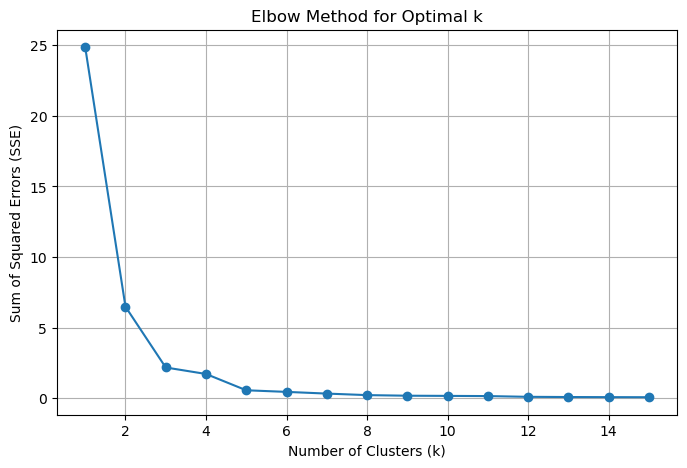

In [519]:
# List to store the SSE for each k
sse = []

# Range of cluster values to test 
k_range = range(1, 16)

# Compute KMeans and SSE for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse.append(kmeans.inertia_)  # inertia_ is the SSE

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [520]:
from sklearn.cluster import KMeans

sse = {}
k_values = range(1, 16)  # You can change the upper limit as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse[k] = kmeans.inertia_  # inertia_ is the SSE for that k

# Print the SSE scores
print("SSE Scores for each k:")
for k, score in sse.items():
    print(f"k = {k}: SSE = {score:.2f}")


SSE Scores for each k:
k = 1: SSE = 24.86
k = 2: SSE = 6.49
k = 3: SSE = 2.18
k = 4: SSE = 1.72
k = 5: SSE = 0.57
k = 6: SSE = 0.46
k = 7: SSE = 0.34
k = 8: SSE = 0.23
k = 9: SSE = 0.18
k = 10: SSE = 0.17
k = 11: SSE = 0.16
k = 12: SSE = 0.11
k = 13: SSE = 0.09
k = 14: SSE = 0.08
k = 15: SSE = 0.08


c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

Based on the analysis, (for now) we will set the optimal number of clusters to be 3.

In [522]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(trained_product_embeddings)


c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [525]:
for cluster in range(3):
    print(f"Cluster #{cluster}")
    products = []

    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]

        # Skip if product name not available
        if prod_id not in product_name_dict:
            print(f"  Skipped unknown product_id: {prod_id}")
            continue

        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_name_dict[prod_id], purchase_count))

    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])


Cluster #0
	 Pulsa Telkomsel 25.000
	 Token PLN 20.000
	 Minyak Goreng Camar 2 Liter
	 Pulsa Telkomsel 300.000
	 Kaos Polo SawitPRO ukuran XL
	 MOP/KCL Cap Daun 50kg
	 Kapur Pertanian Kebomas 50 Kg
	 Kupon Belanja 50.000
	 Kaos Agen Inovasi SawitPRO size L
	 Kupon Belanja 150.000
Cluster #1
	 Minyak Goreng Harumas 1 liter
	 Token PLN 200.000
	 Pulsa Telkomsel 100.000
	 MOP/KCL Canada Cap Mahkota 50kg
	 Dokter Sawit Konsultasi
	 Token PLN 100.000
	 Minyak Goreng Camar 1 liter - Ramadhan Berkah
	 TSP China Cap Daun 50kg
	 Pulsa Telkomsel 50.000
	 NPK Mutiara 16-16-16 50kg
Cluster #2
	 Topi SawitPRO Hijau
	 Fosfat Phosgreen 25kg
	 Kupon Belanja 200.000
	 SP-26 Petro 25kg
	 Uji Sampel Daun
	 Kupon Belanja 25.000
	 Benih Sawit Topaz 1-3 Seri 4 (100 butir)


In [526]:
from collections import defaultdict
import numpy as np

# Define user
user_id = 'a294d318-84f6-4511-b3d6-b3308a25d54a'

# Get user's purchased products
user_products = merged_data[merged_data['user_id'] == user_id]['product_id'].unique()

# Store recommendations from association rules
recommendation_dict = {}

# --- Association Rule Mining ---
for pid in user_products:
    related_rules = rules[rules['antecedents'].apply(lambda x: pid in x)]
    for _, row in related_rules.iterrows():
        for consequent in row['consequents']:
            if consequent not in user_products:
                if consequent not in recommendation_dict or row['lift'] > recommendation_dict[consequent]:
                    recommendation_dict[consequent] = row['lift']

# Sort by lift
sorted_recommendations = sorted(recommendation_dict.items(), key=lambda x: x[1], reverse=True)
top_recommendations = sorted_recommendations[:10]
recommended_ids = {pid for pid, _ in top_recommendations}

# --- KMeans Fallback if needed ---
needed = 10 - len(top_recommendations)
if needed > 0:
    cluster_ids = set()

    # Identify clusters user's products belong to
    for pid in user_products:
        if pid in train_set.productid2idx:
            cluster_label = kmeans.labels_[train_set.productid2idx[pid]]
            cluster_ids.add(cluster_label)

    cluster_fallbacks = []

    for cluster in cluster_ids:
        for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
            fallback_pid = train_set.idx2productid[prod_idx]

            if (
                fallback_pid not in user_products and
                fallback_pid not in recommended_ids and
                fallback_pid in product_name_dict
            ):
                purchase_count = len(merged_data[merged_data['product_id'] == fallback_pid])
                cluster_fallbacks.append((fallback_pid, purchase_count))
                recommended_ids.add(fallback_pid)

            if len(cluster_fallbacks) >= needed:
                break
        if len(cluster_fallbacks) >= needed:
            break

    # Sort fallback by popularity
    cluster_fallbacks = sorted(cluster_fallbacks, key=lambda x: x[1], reverse=True)[:needed]
    top_recommendations.extend([(pid, 0.0) for pid, _ in cluster_fallbacks])

# --- Final Output ---
print(f"\nTop 10 Recommendations for User {user_id}:")
for i, (pid, lift_score) in enumerate(top_recommendations, start=1):
    name = product_name_dict.get(pid, "Unknown Product")
    tag = f"Lift: {lift_score:.2f}" if lift_score > 0 else "KMeans Fallback"
    print(f"{i}. {name} (Product ID: {pid}) — {tag}")



Top 10 Recommendations for User a294d318-84f6-4511-b3d6-b3308a25d54a:
1. Token PLN 100.000 (Product ID: 5952d124-7dc6-4a6a-baa2-e2e502ecd6fe) — Lift: 12.17
2. Token PLN 50.000 (Product ID: 033ec187-4af1-4143-bc64-8c258f4fbd84) — Lift: 9.74
3. Pulsa Telkomsel 100.000 (Product ID: 5c3f5704-51bb-4744-a77e-e8488dafbede) — Lift: 2.90
4. MOP/KCL Canada Cap Mahkota 50kg (Product ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd) — KMeans Fallback
5. Urea Pusri NS 50 50kg (Product ID: 96329d75-9cb4-4991-8467-8ea1e0e024d3) — KMeans Fallback
6. Dolomite M-100 50kg (Product ID: 9e7cc609-f4ef-4246-89e7-756861e623d8) — KMeans Fallback
7. Dokter Sawit Konsultasi (Product ID: 9aab3102-3aee-4639-b7f6-4dd33933c675) — KMeans Fallback
8. Pulsa Telkomsel 200.000 (Product ID: c82ff2f1-5062-4ec8-84c6-546949d1b4e6) — KMeans Fallback
9. NPK Phonska Plus 15-15-15 25kg (Product ID: 6c27fc9c-e7e9-4e9b-9017-292175250df1) — KMeans Fallback
10. Pulsa Telkomsel 150.000 (Product ID: 234a0d4e-b200-4c53-81a7-fc0161679874) — KM

In [ ]:
import joblib

# Bundle components for association + KMeans fallback recommender
assoc_kmeans_model = {
    'rules': rules,
    'kmeans': kmeans,
    'train_set': train_set,
    'product_name_dict': product_name_dict,
    'merged_data': merged_data
}

# Save to file
joblib.dump(assoc_kmeans_model, 'assoc_kmeans_model.pkl')
